# Training code for Fastai U-net architecture on wavefield dataset
Los Alamos Dynamics Summer School (LADSS)  
Team: DeepWaves  
Date: August 17, 2020  
Author: Kelly Ho (kellyh27@uw.edu)  
See CNN_model_training_instructions_KH.doc in the documentation folder for details.

Create 7 folders beforehand:

1. images_real: store original images
2. labels_real: store original labels
3. images: store original and augmented images
4. labels: store original and augmented labels
5. test_images_real: store testset
6. models: store trained models
7. noise: store noisy images for noise case study

(exp folder was created for experimental data and test folder was created for additional small width defects testset. These two folders are optional and can be combined with the test_images_real folder.)


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 36.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
# Change the interpret.py file in the files system 
# Click the folder icon on the left and then click the folder name '..'
# The path to the interpret.py file is '/usr/local/lib/python3.6/dist-packages/fastai/vision/interpret.py'
# Delete the original interpret.py and upload the new interpret.py
import fastai
fastai.__file__

'/usr/local/lib/python3.6/dist-packages/fastai/__init__.py'

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Import fastai
from fastai.vision import *
from fastai.vision.interpret import SegmentationInterpretation

# Clear GPU cache
from torch import cuda as cd

# Import IoU and Dice metrics
import torch
from torch.nn import functional as F

# For Gaussian noise transforms
from skimage.util import random_noise
import PIL

# For importing files and plotting images
import os
import sys
import random
import matplotlib
import numpy as np
from PIL import Image
from skimage import io

In [ ]:
# Mount Google Drive to see changes in the files system (optional)
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Create main folder path
folder_path = '/content/gdrive/My Drive/Deep Waves'
sys.path.append(folder_path)

In [ ]:
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [ ]:
# Return Dice coefficient, or F1 score = 2*intersection / cardinality
def dice(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the dice coefficient
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_coeff
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    dice_coeff = (2 * intersection / (cardinality + eps)).mean()   # find mean of class dice values
    return dice_coeff

In [ ]:
# Add Guassian noise to images
# Use var=0.004 for this model
def Gaussian(img):
  np_img = np.array(img)
  noise_img = random_noise(np_img,mode='gaussian',var=0.004) # var=0.01 by default
  noise_img = (255*noise_img).astype(np.uint8)
  pil_img = PIL.Image.fromarray(noise_img)
  return pil_img

In [ ]:
# Original images and labels are not augmented
# Final images and labels include the original and agumented data

# Clear GPU cache
cd.empty_cache()

# Get training data and create path to the main folder
path = Path(folder_path)

# Import classes for classification
codes = np.loadtxt(path/'codes.txt',dtype=str)

# Use 'Void' class for background
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['10'] # plate thickness = 10 mm

# Create path for the original images and labels
path_rd_imgs = path/'images_real'
path_rd_lbls = path/'labels_real'

# Create path for the final images
path_img = path/'images'

# Create path for the final labels
path_lbl = path/'labels'

# Create path for the test images
path_test = path/'test_images_real' # testset simulated from ANSYS
test = path/'test' # testset for small width defects
exp = path/'exp' # experimental data

# Create path of the noisy images
path_noise = path/'noise'

In [ ]:
# Save original images in final image folder
image = []

folder = path_rd_imgs
for filename in os.listdir(folder):
  img = Image.open(folder/filename)
  img.save(path_img/filename)
  image.append(img)
print(len(image)) # Check number of images saved

503


In [ ]:
# Save original labels in final label folder
label = []

folder = path_rd_lbls
for filename in os.listdir(folder):
  lbl = Image.open(folder/filename)
  lbl.save(path_lbl/filename)
  label.append(lbl)
print(len(label)) # Check number of labels saved

503


In [ ]:
# Name augmented images and labels by adding 'aug0' in the original filenames
# aug0: 180 degree rotation
def addaug(name, k):
  j = 0
  while (name[j] != "."):
    j = j + 1
  rename = name[:j]+'_aug'+str(k)+name[j:]
  return rename

In [ ]:
# Perform data augmentation (180 degree rotation) on both the original images and labels
# Save the augmented images and labels in the final image and label folders
angle = 180

augfnames = get_image_files(path_rd_imgs)
auglblnames = get_image_files(path_rd_lbls)

for i in range(0,len(augfnames)):
  imgpath = augfnames[i]
  lblpath = auglblnames[i]
  img = Image.open(imgpath)
  lbl = Image.open(lblpath)
  imgtfms = img.rotate(angle)
  lbltfms = lbl.rotate(angle)
  imgtfms.save(path_img/addaug(imgpath.name,0))
  lbltfms.save(path_lbl/addaug(lblpath.name,0))

In [ ]:
# Name Gaussian noise images and labels by adding 'gaussian' in the original filenames
def addgaussin(name):
  l = 0
  while (name[l] != "."):
    l = l + 1
  rename = name[:l]+'_gaussian'+name[l:]
  return rename

In [ ]:
# Add Gaussian noise only to the original and 180 degree rotated images
# Gaussian noise is not applied to the labels
# Save noisy images and labels in the final image and label folders
image_list = []
label_list = []

folder = path_img
for filename in os.listdir(folder):
  img = Image.open(folder/filename)
  noise = Gaussian(img)
  noise.save(path_img/addgaussin(filename))
  image_list.append(noise)

folder = path_lbl
for filename in os.listdir(folder):
  lbl = Image.open(folder/filename)
  lbl.save(path_lbl/addgaussin(filename))
  label_list.append(lbl)

print(len(image_list),len(label_list)) # Check number of images and labels saved

503 503


In [ ]:
# Check number of items in the final image and label folders
imgList = SegmentationItemList.from_folder(path_img)
lblList = SegmentationLabelList.from_folder(path_lbl)
print(imgList)
print(lblList)

SegmentationItemList (2012 items)
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images
SegmentationLabelList (2012 items)
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/labels


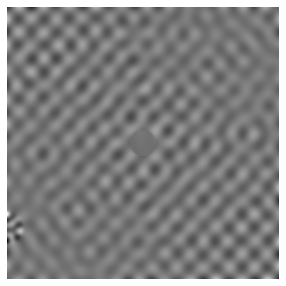

In [ ]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# Show example image
img_f = fnames[1000]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
# Determine type of image
filename = str(img_f)
if '_magnitude' in filename:
    token = '_mag'
elif '_real' in filename:
    token = '_real'
elif '_imaginary' in filename:
    token = '_imaginary'
else:
    print("Error: image needs to contain one of the above")

In [ ]:
# Function to get label path from image filename
get_y_fn = lambda x: path_lbl/f'{x.stem.split(token)[0]}_mask{x.stem.split(token)[1]}{x.suffix}'

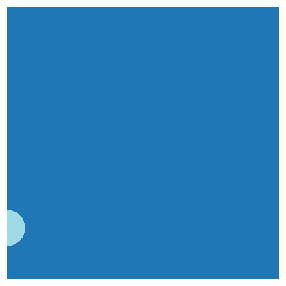

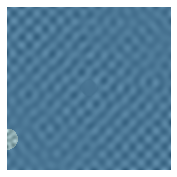

In [ ]:
# Show image mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)
img.show(y=mask)

In [ ]:
# Training parameters
src_size = np.array(mask.shape[1:])
bs = 16 # Batch size

In [ ]:
# Setup Data
src = (SegmentationItemList.from_folder(path_img) 
       # GET images
       # fastai.vision.data.SegmentationItemList :: ItemList
       .split_by_rand_pct()
       # SPLIT valid/train randomly (20% valid/ 80% train by default)
       .label_from_func(get_y_fn, classes=codes))
       # LABEL classes
       # fastai.data_block.LabelLists

# Print out details about the dataset (number of training and validation dataset)
print(src)

# Transforms to perform on the fly: horizontal and vertical flips
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=None,max_zoom=1,
                     max_lighting=None,max_warp=None,p_lighting=0)

# Create data
data = (src.transform(tfms,size=src_size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
# fastai.basic_data.DataBunch

# Show data
data.show_batch(rows=3, figsize=(12,9))

LabelLists;

Train: LabelList (1610 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images;

Valid: LabelList (402 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images;

Test: None


In [ ]:
# Create U-net Learner object
learn = unet_learner(data,models.resnet34,metrics=[IoU,dice])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,IoU,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


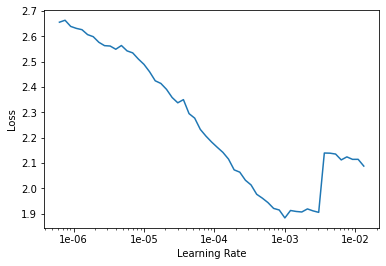

In [ ]:
# Train model
# Stage 1 : Optimize learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Pick learning rate based on the previous plot
lr = 5e-04

# Train the last layer of the model with 30 cycles and the picked learning rate 
# (can train the model with more cycles)
learn.fit_one_cycle(30,slice(lr),pct_start=0.3)

epoch,train_loss,valid_loss,IoU,dice,time
0,1.293814,1.041590,0.095344,0.129373,03:32
1,1.045623,0.857257,0.130090,0.177751,03:28
2,1.019088,0.871675,0.120299,0.170830,03:27
3,0.867052,0.682061,0.158842,0.220814,03:26
4,0.800952,0.703989,0.162756,0.227671,03:26
5,0.755655,0.626690,0.209686,0.281842,03:25
6,0.677970,0.536563,0.236026,0.313369,03:24
7,0.631040,0.546500,0.208093,0.275130,03:24
8,0.666722,0.605354,0.213958,0.283483,03:23
9,0.586886,0.523286,0.240254,0.322187,03:22


In [ ]:
# Save the stage 1 trained model in the model folder
learn.save(folder_path+'/models/stage-1-real-noise0.004') 

In [ ]:
# Load the previously saved stage 1 trained model
learn.load(folder_path+'/models/stage-1-real-noise0.004')

Learner(data=ImageDataBunch;

Train: LabelList (1610 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images;

Valid: LabelList (402 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

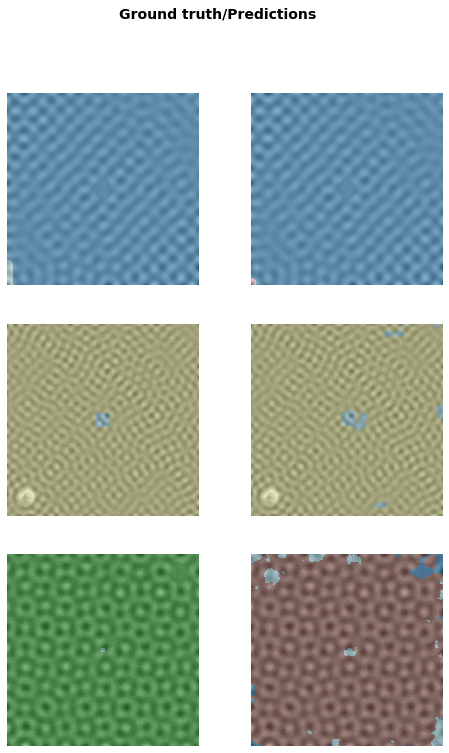

In [ ]:
# Show training results 
learn.show_results(rows=3)

epoch,train_loss,valid_loss,IoU,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


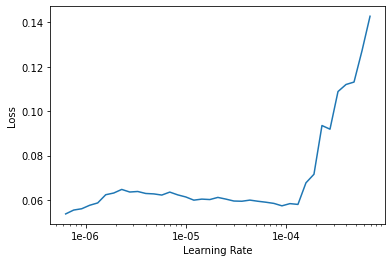

In [ ]:
# Unfreeze all the layers of the model to fine tune and improve the accuracy
learn.unfreeze()

# Train model
# Stage 2 : Optimize learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Pick learning rate based on the previous plot
lower_lr_bound = 1e-05

# upper_lr_bound learning rate can be manually picked from the plot or use lr/5
upper_lr_bound = 1e-04 # or lr/5

# Train all the layers of the model with 40 cycles and the picked learning rate 
# (can train the model with more cycles)
learn.fit_one_cycle(40,slice(lower_lr_bound,upper_lr_bound))

epoch,train_loss,valid_loss,IoU,dice,time
0,0.059965,0.063630,0.626557,0.688760,03:30
1,0.061101,0.060766,0.628764,0.690636,03:30
2,0.061699,0.059887,0.632218,0.693069,03:30
3,0.065198,0.063845,0.626996,0.689585,03:30
4,0.063668,0.061146,0.624204,0.687188,03:30
5,0.062465,0.090685,0.607736,0.673388,03:30
6,0.053375,0.052061,0.648421,0.707080,03:30
7,0.059722,0.062846,0.633068,0.694068,03:30
8,0.064766,0.060178,0.631859,0.694615,03:30
9,0.047628,0.087831,0.639219,0.701050,03:30


In [ ]:
# Save the stage 2 trained model in the model folder
# return_path=True shows the path to the saved model
learn.save(folder_path+'/models/stage-2-real-noise0.004',return_path=True)

PosixPath('/content/gdrive/My Drive/Deep Waves/models/stage-2-real-noise0.04.pth')

In [ ]:
# Load the stage 2 trained model 
learn.load(folder_path+'/models/stage-2-real-noise0.004')

Learner(data=ImageDataBunch;

Train: LabelList (1610 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images;

Valid: LabelList (402 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: /content/gdrive/My Drive/Deep Waves/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

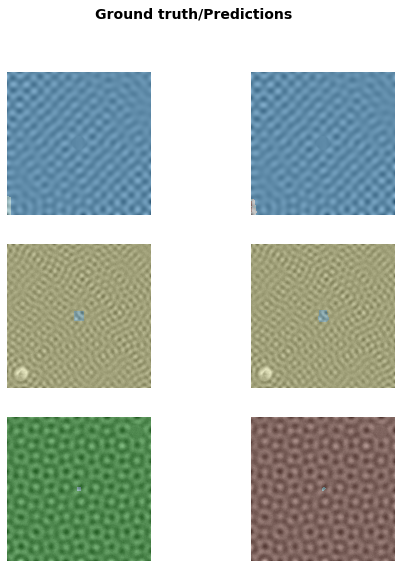

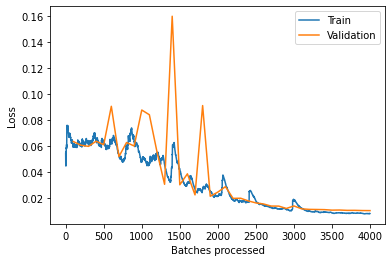

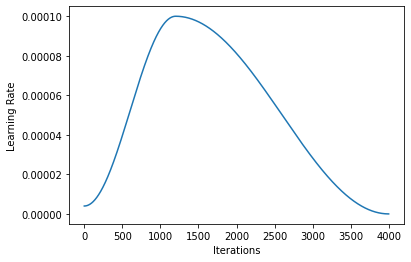

In [ ]:
# Show training results
learn.show_results(rows=3,figsize=(8,9))
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [ ]:
# Create interpretation methods for segmenatation models
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
# Create constant colors for classes
classes = [x for x in learn.data.classes]

# A color list for 10 thicknesses
color_list = [(0,0,127/255), (0,0,1), (0,127/255,1), (0,1,1), (60/255,1,195/255), (195/255,1,60/255), (1,1,0), (1,127/255,0), (1,0,0), (127/255,0,0)]

# Use this workaround to ensure a constant colormap
cmap = matplotlib.colors.ListedColormap(color_list)
boundaries = [0,1,2,3,4,5,6,7,8,9,10]
norm = matplotlib.colors.BoundaryNorm(boundaries,cmap.N,clip=True)

label,score
10,0.99924
2,0.93912
4,0.90479
1,0.899346
3,0.863985
5,0.824284
8,0.819884
6,0.807732
7,0.791061
9,0.765849


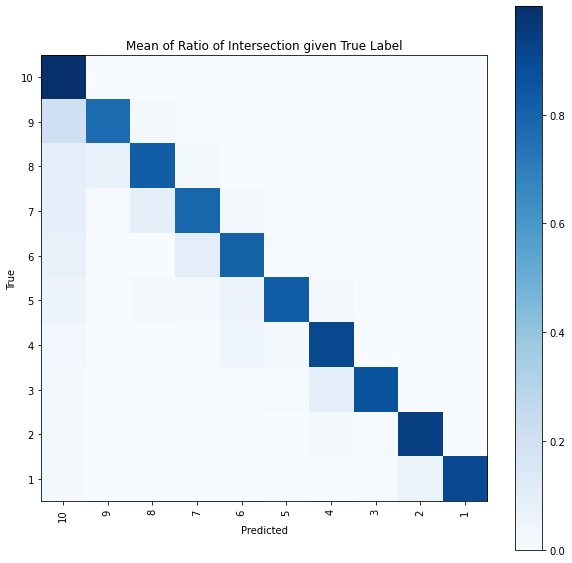

In [ ]:
# Plot confusion matrix for the validation dataset and the score for each label
mean_cm, single_img_cm = interp._generate_confusion()
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# See the result for an image in the validation dataset
i = 0
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
interp.show_xyz(i, sz=15)

0.11768746376037598 0.11768999999999608


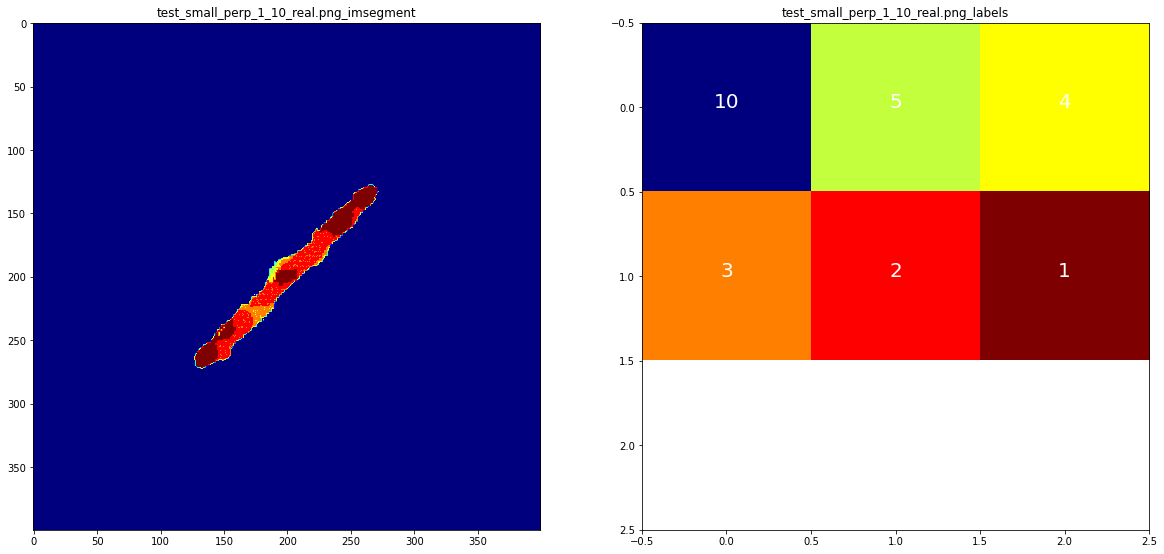

In [ ]:
# Get the estimation time for processing and getting predicitons for an image 
img = open_image(test/'test_small_perp_1_10_real.png')
a = time.time()
a1 = time.clock()
pred = learn.predict(img)
interp._interp_show(pred[0],classes,title_suffix='test_small_perp_1_10_real.png',cmap=cmap,norm=norm)
b = time.time()
b1 = time.clock()
print(b-a, b1-a1)

/usr/local/lib/python3.6/dist-packages/fastai/vision/interpret.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axes=plt.subplots(1,2,figsize=(sz,sz))
/usr/local/lib/python3.6/dist-packages/fastai/vision/interpret.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axes=plt.subplots(1,2,figsize=(sz,sz))
/usr/local/lib/python3.6/dist-packages/fastai/vision/interpret.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

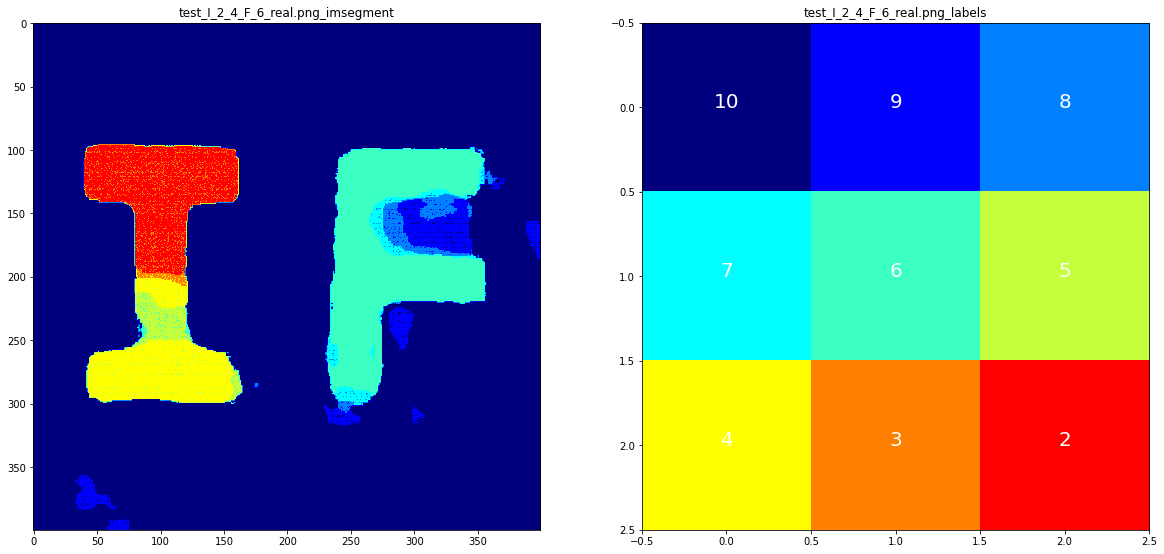

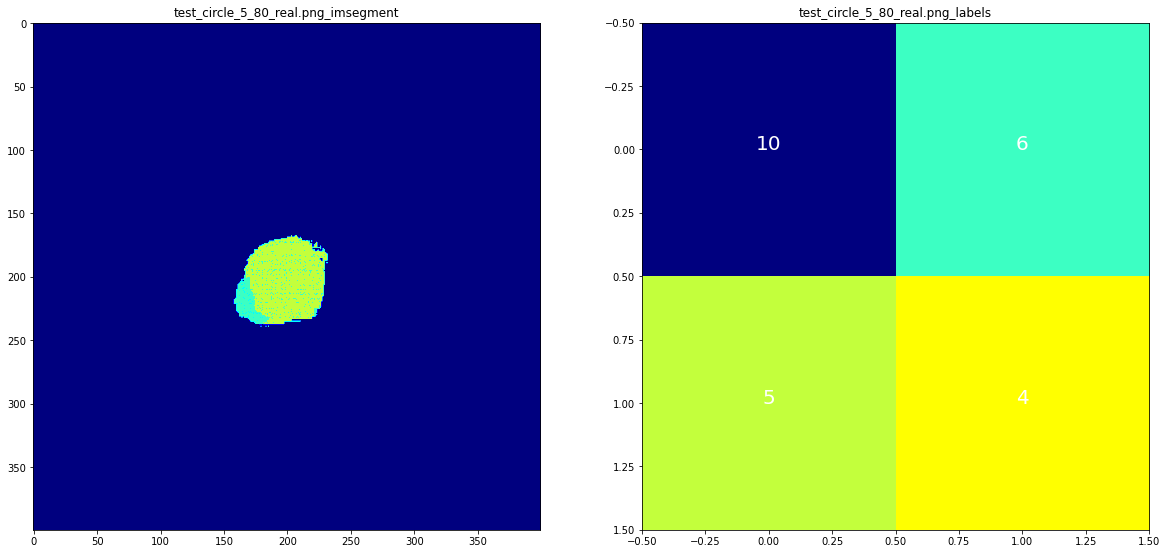

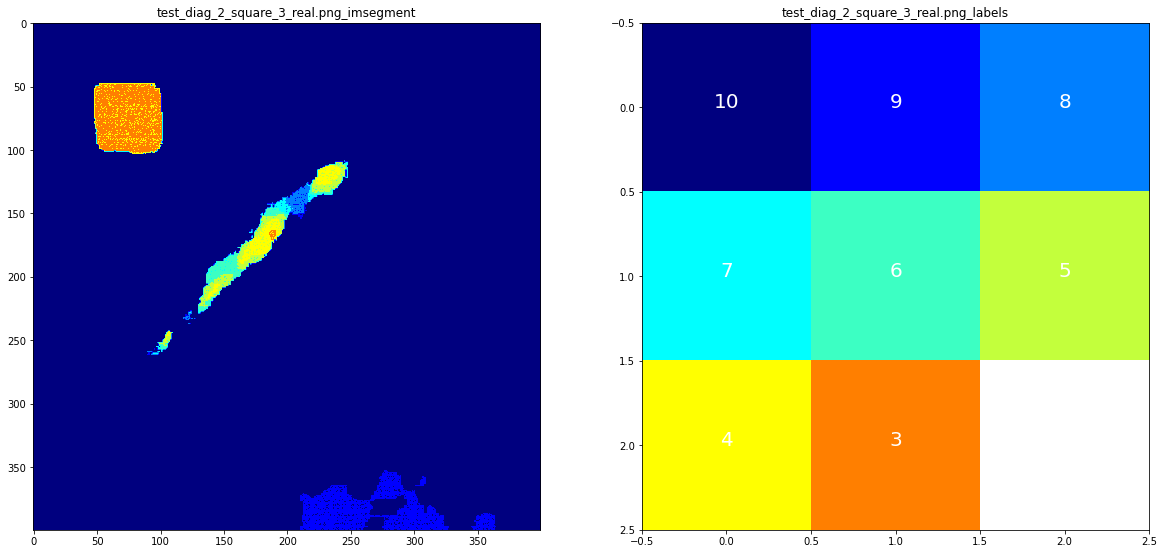

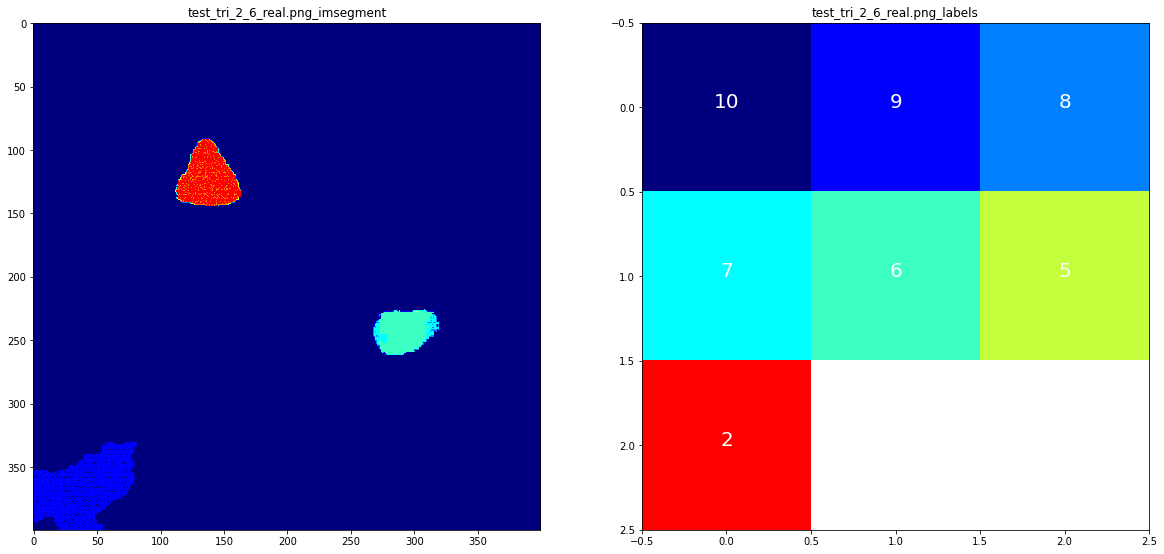

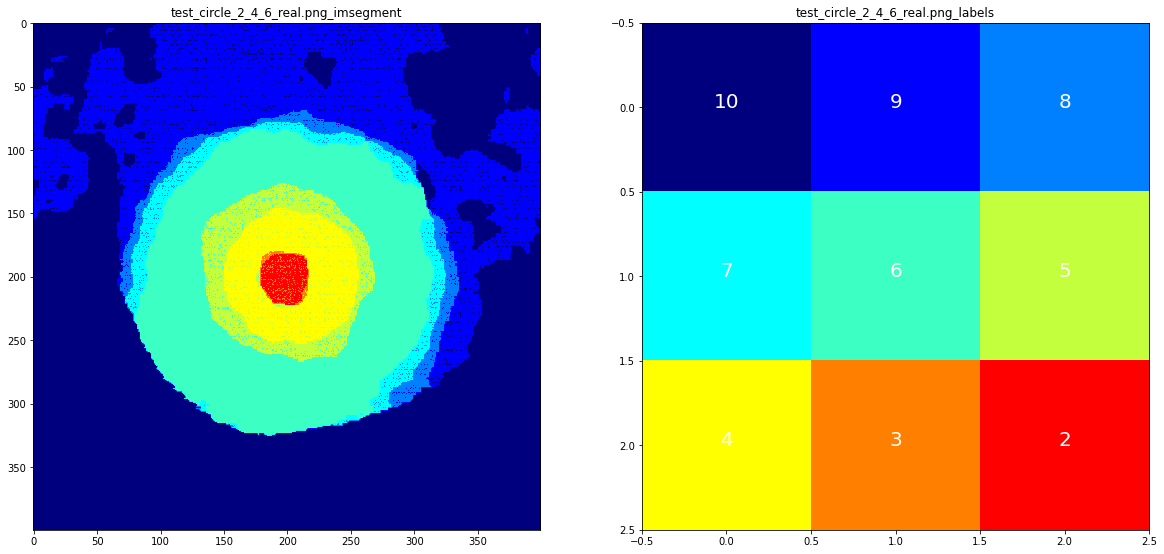

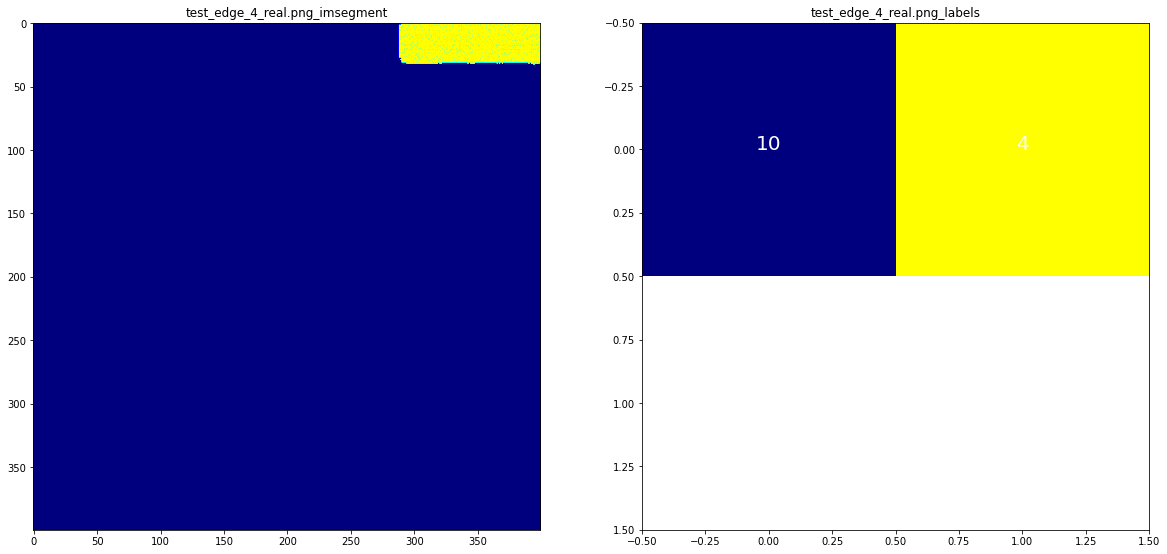

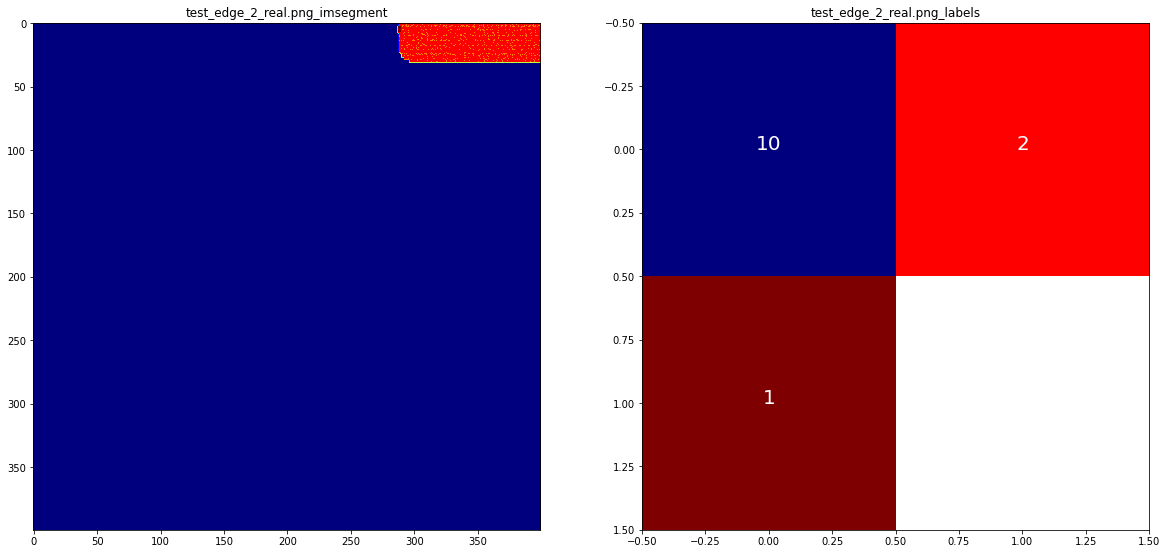

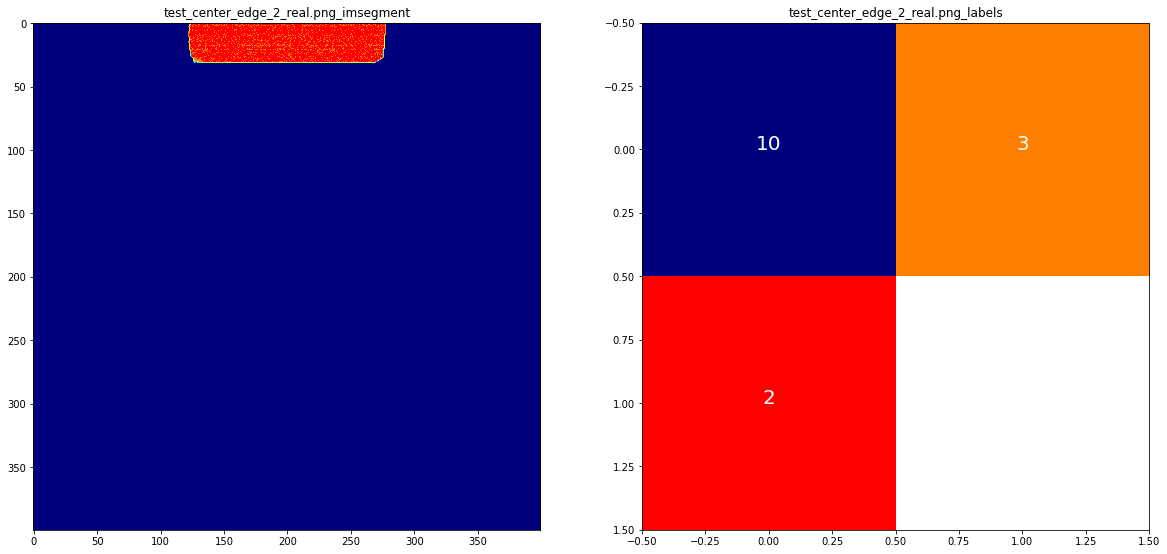

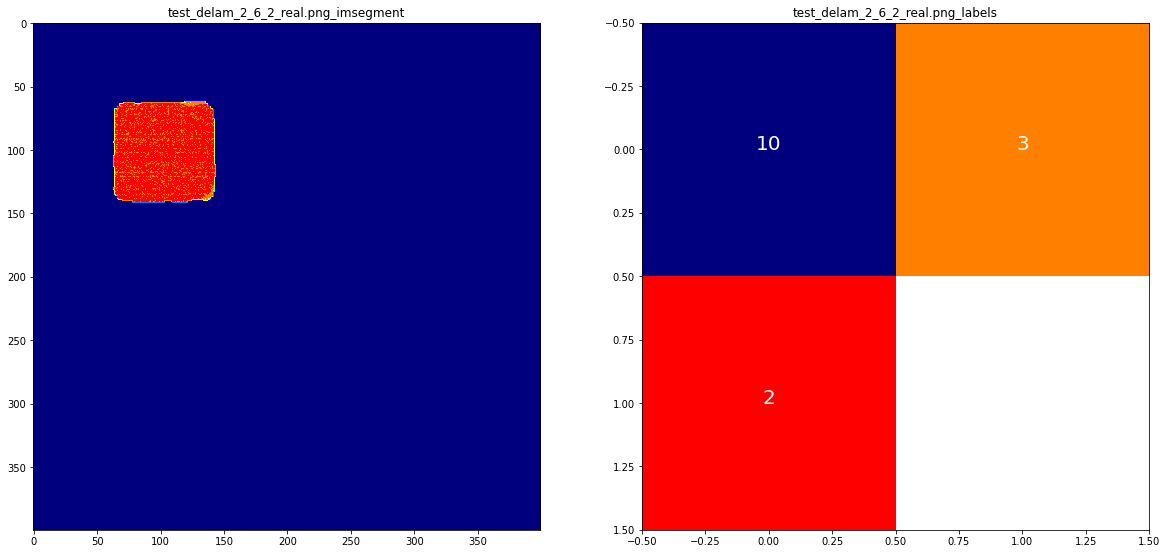

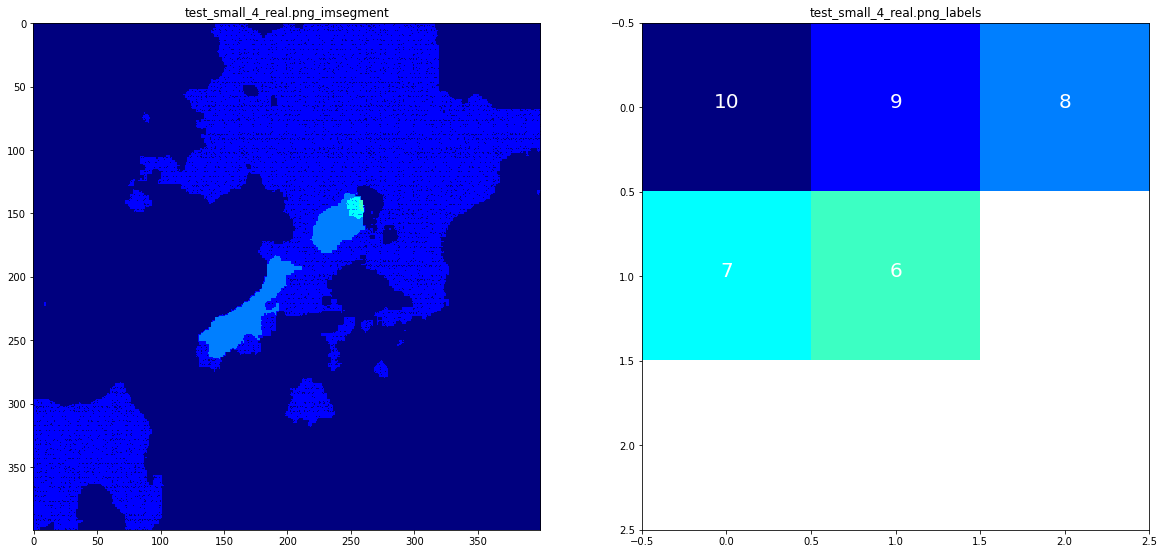

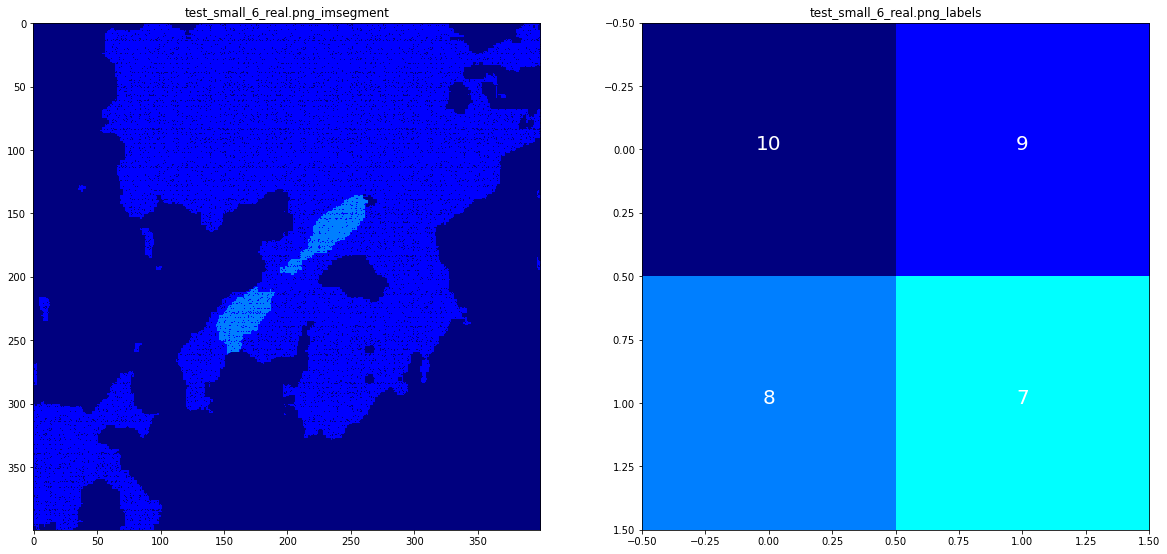

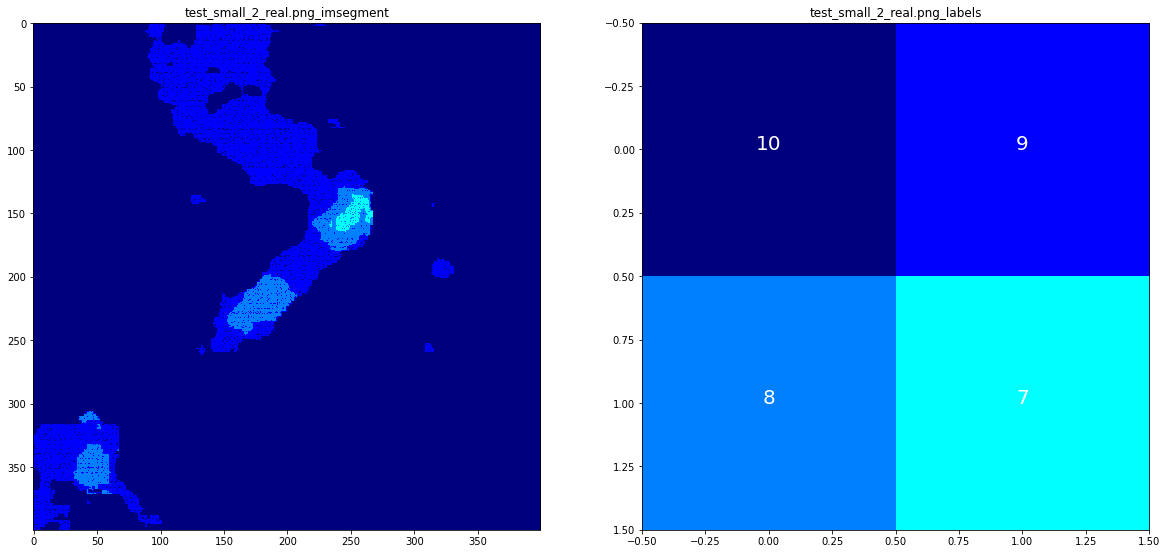

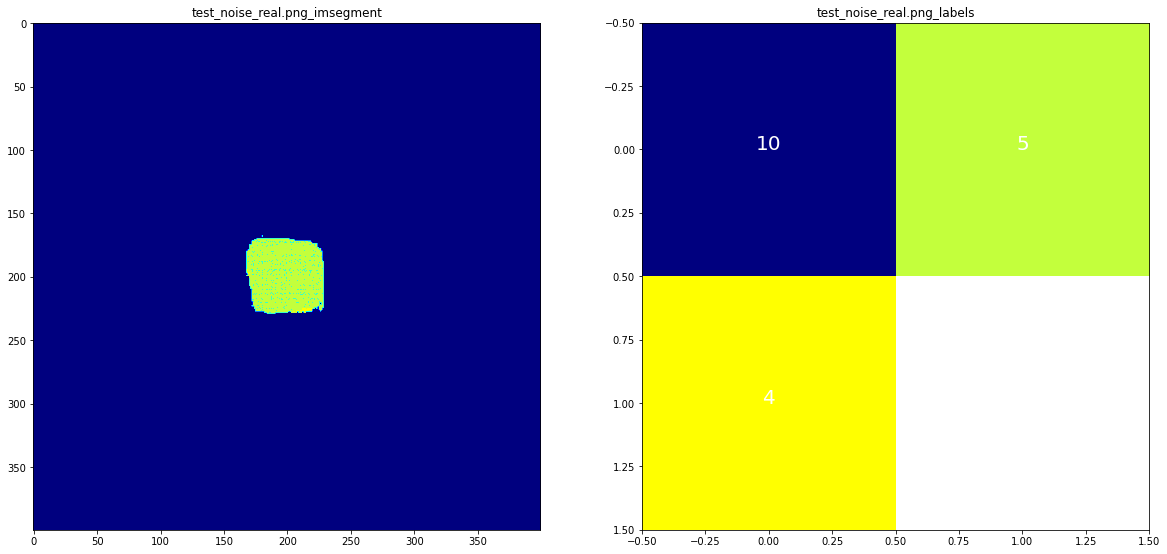

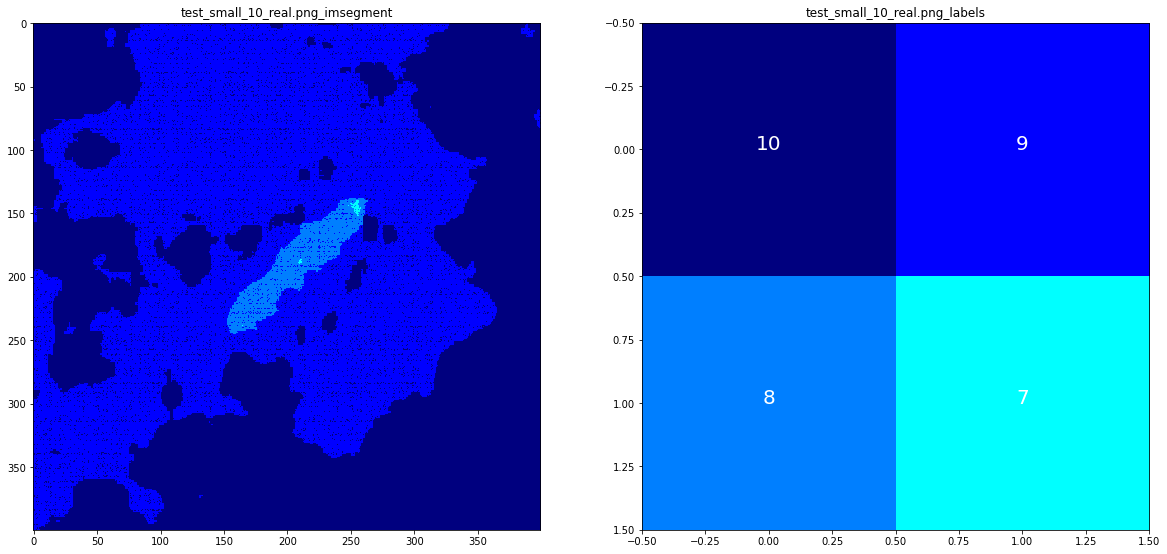

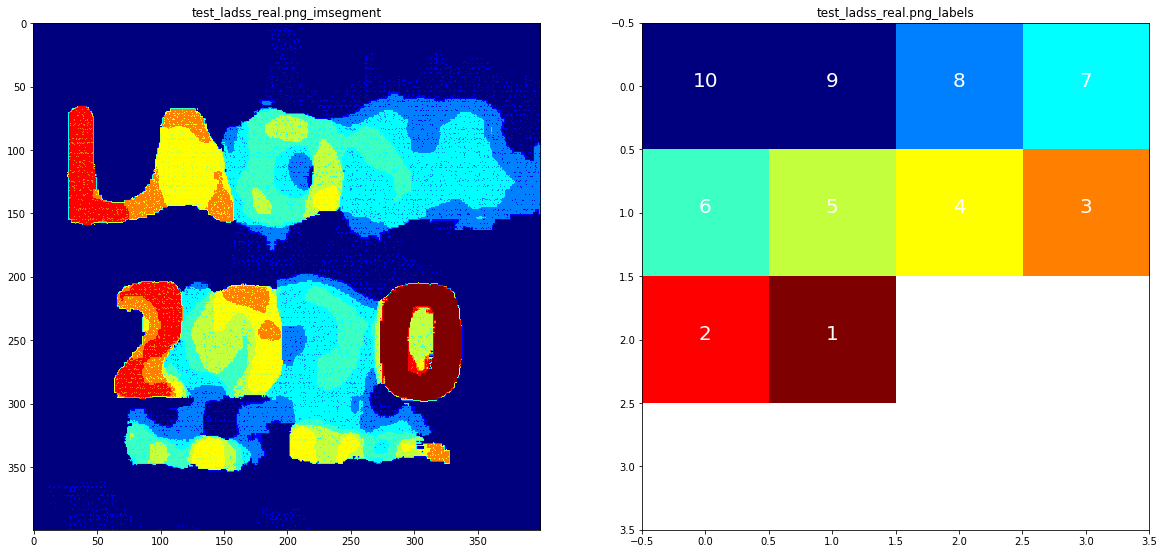

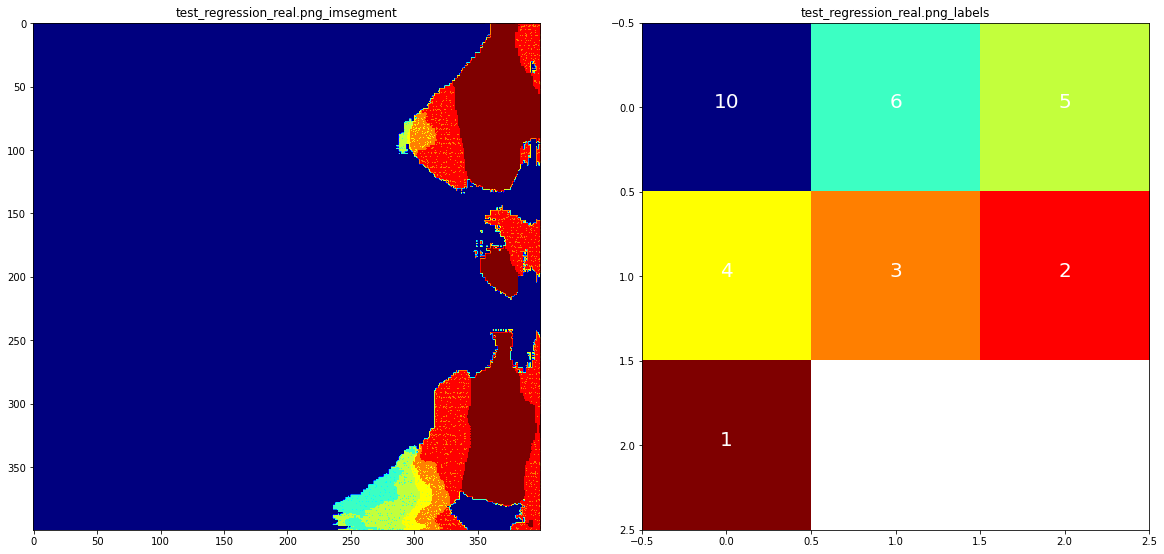

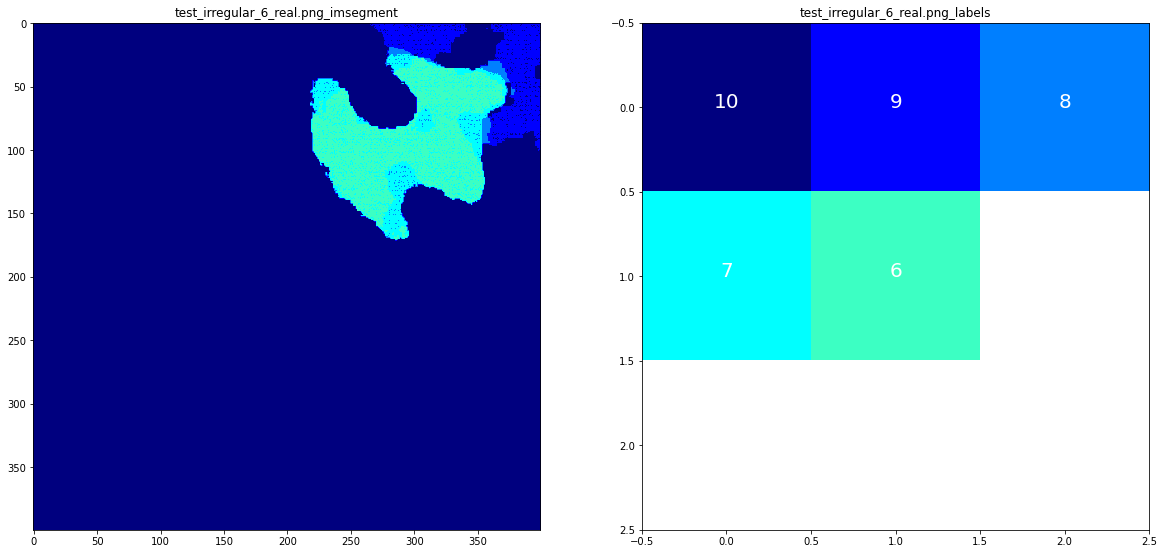

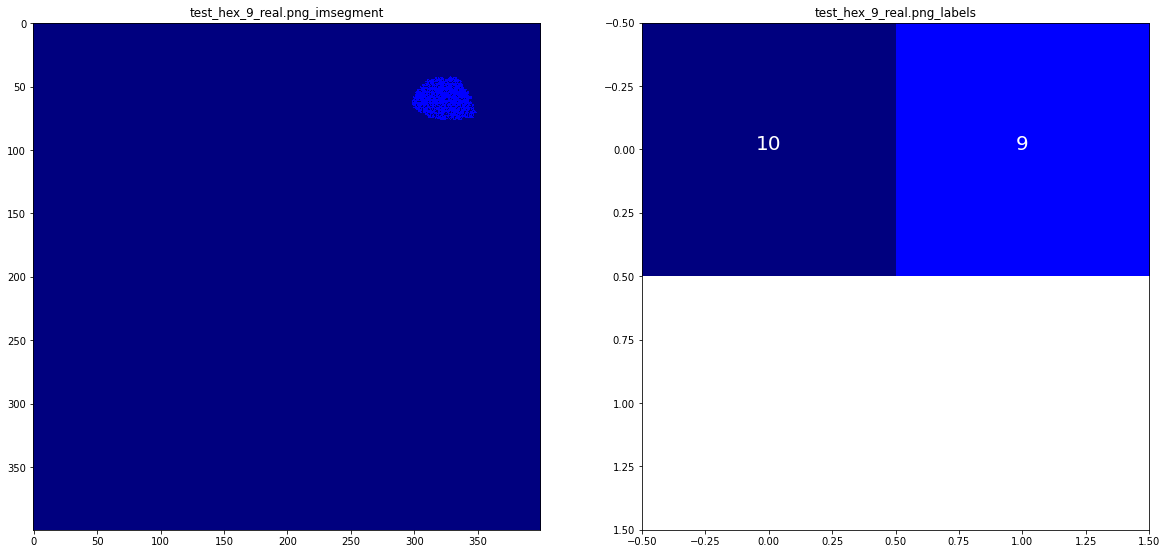

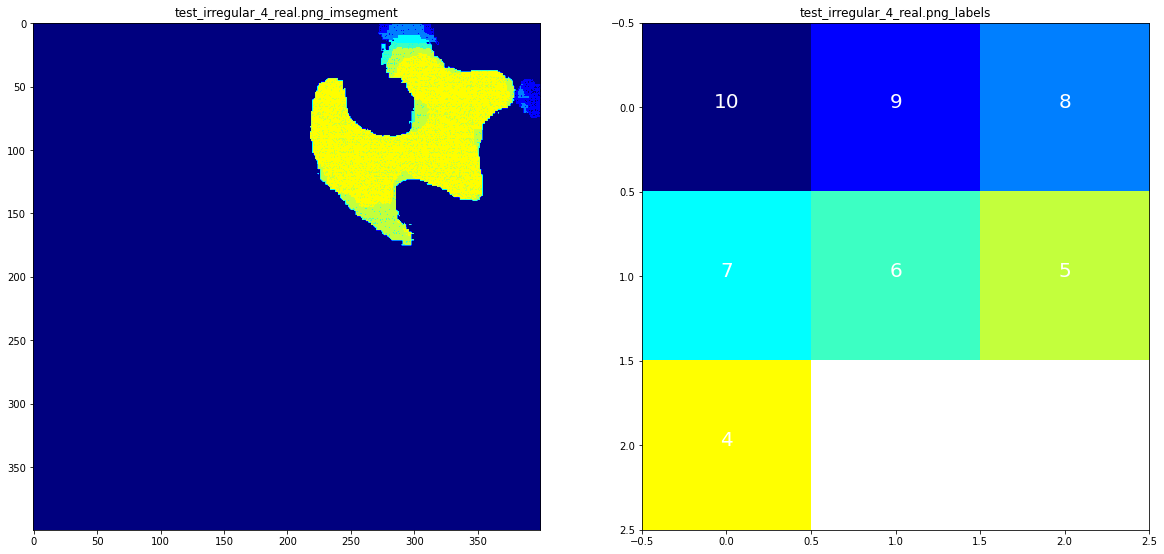

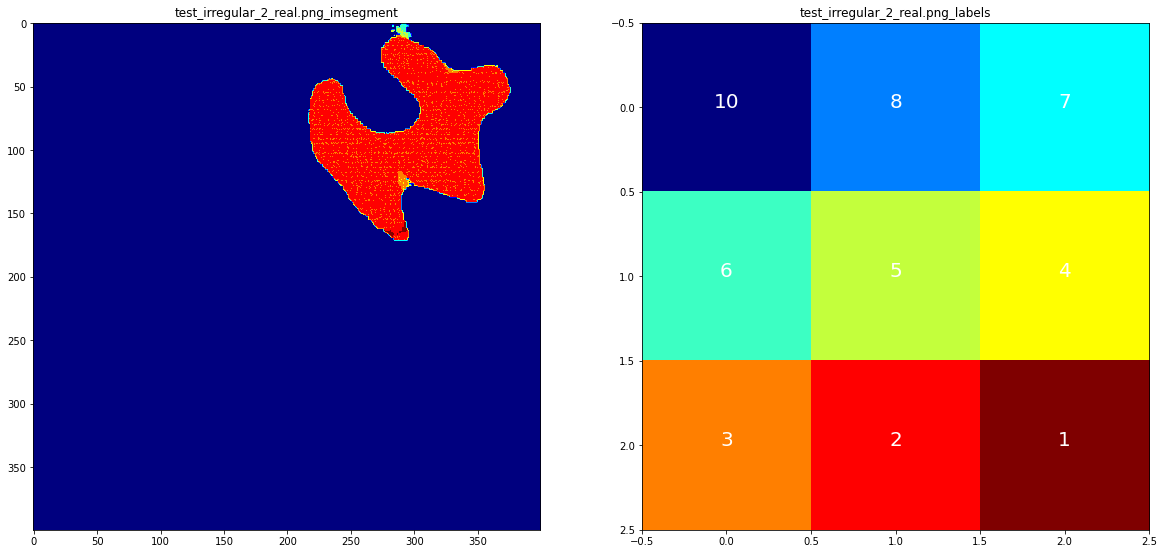

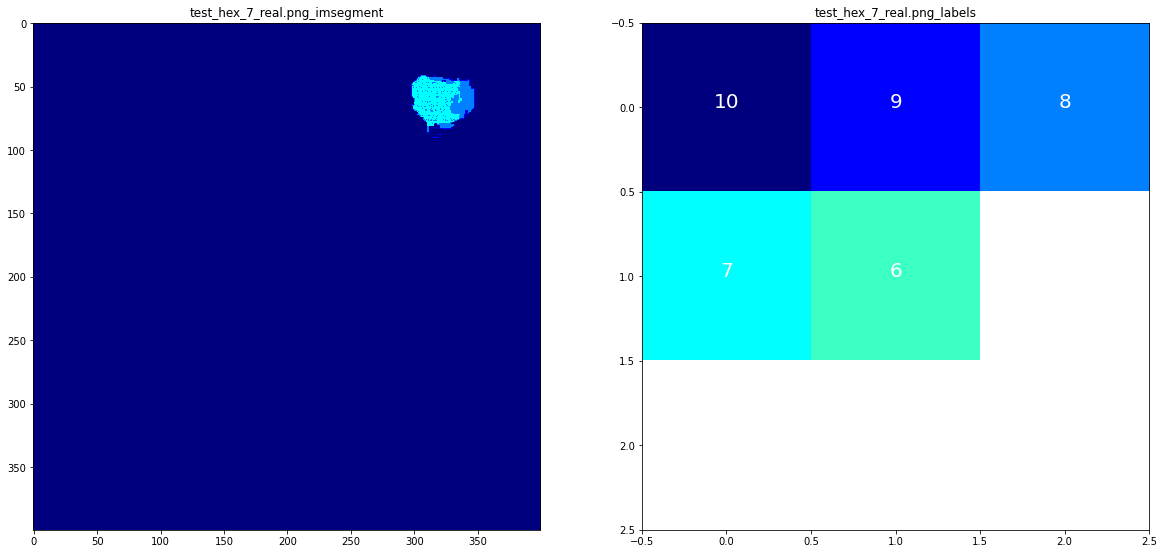

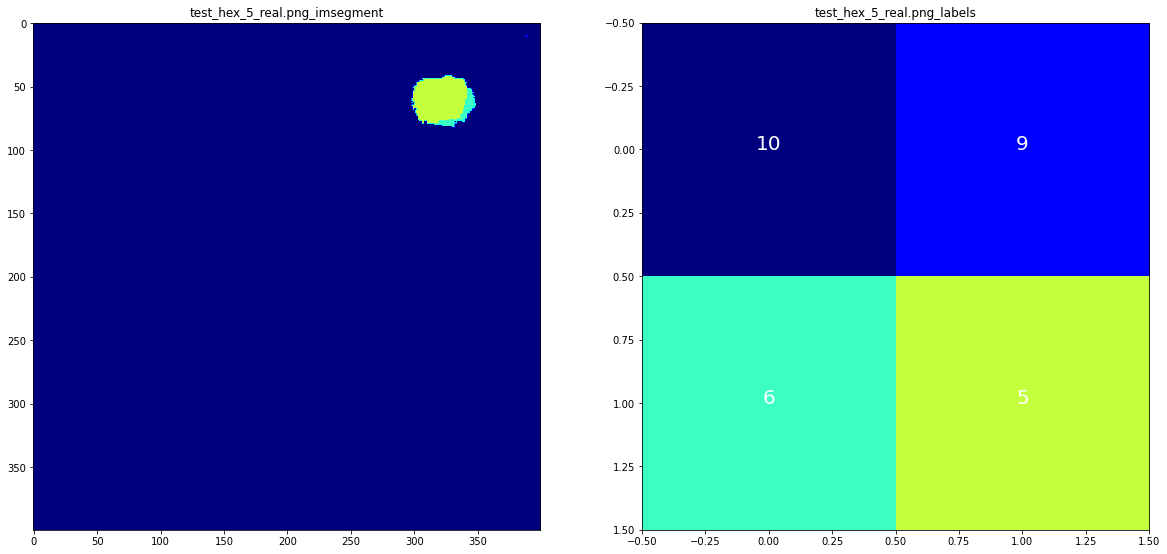

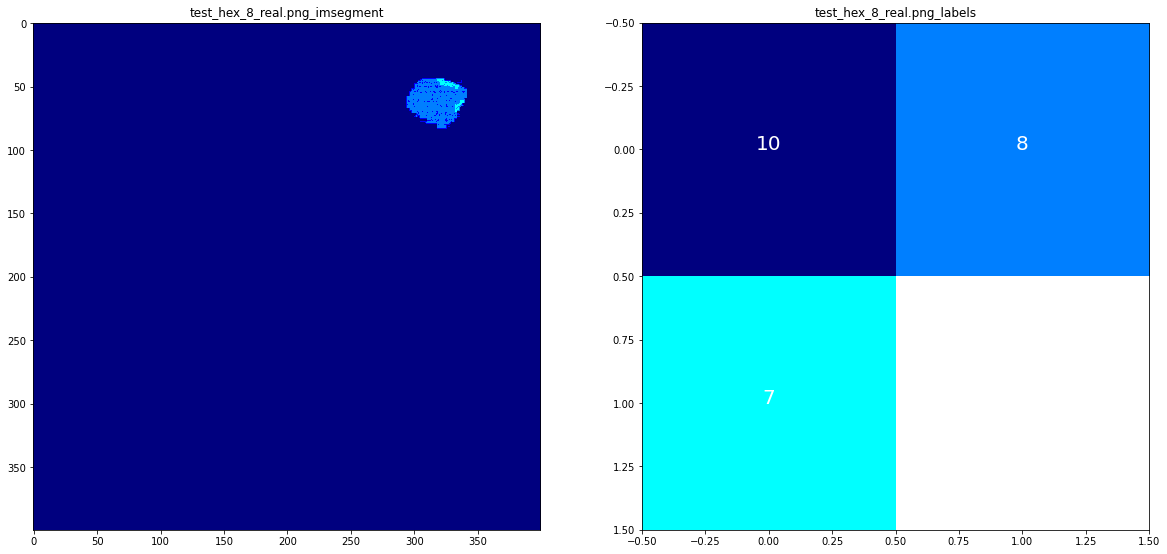

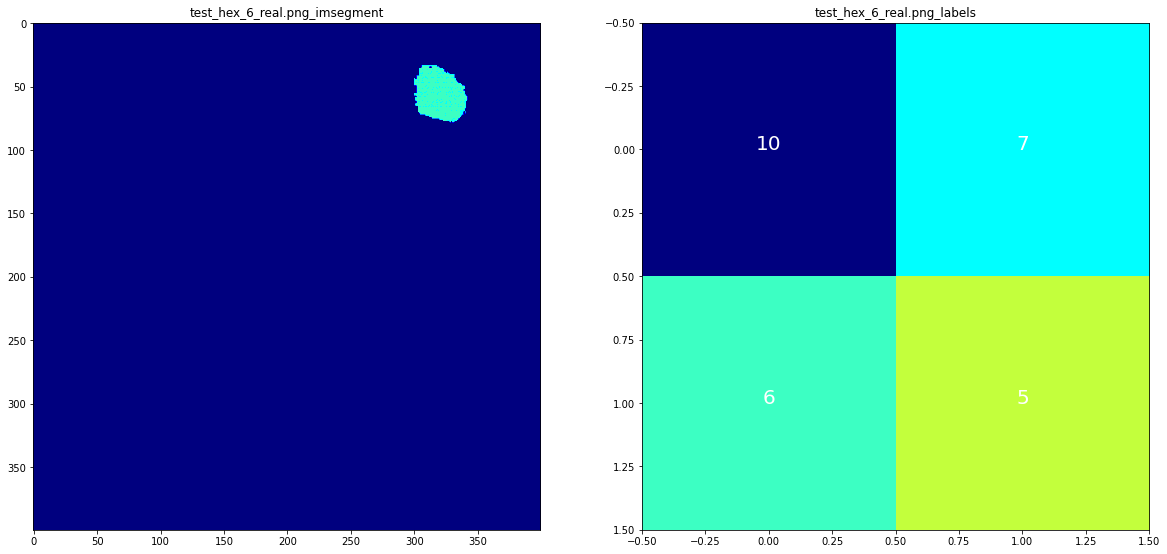

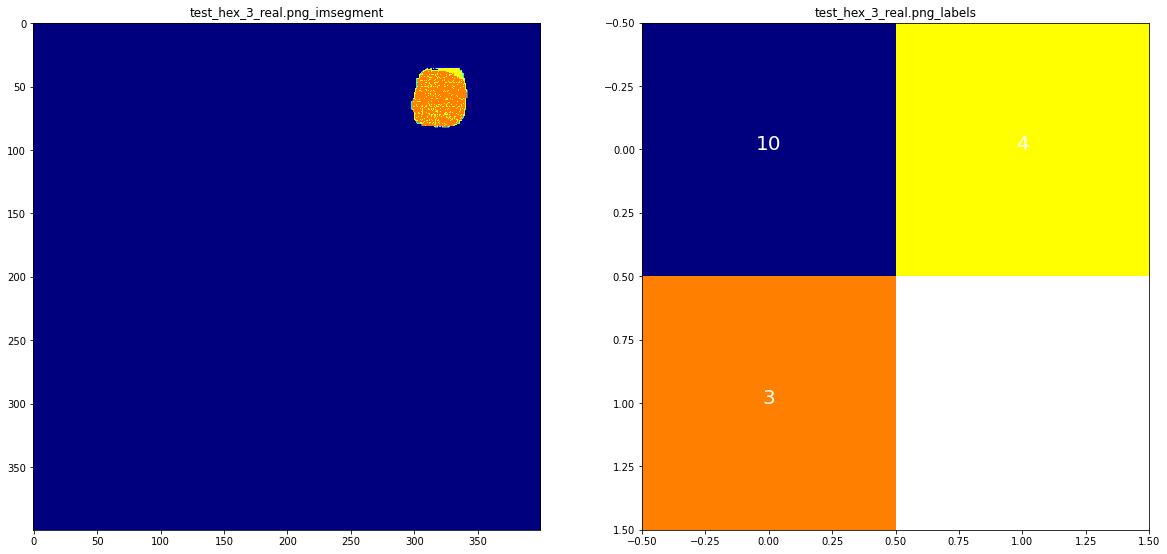

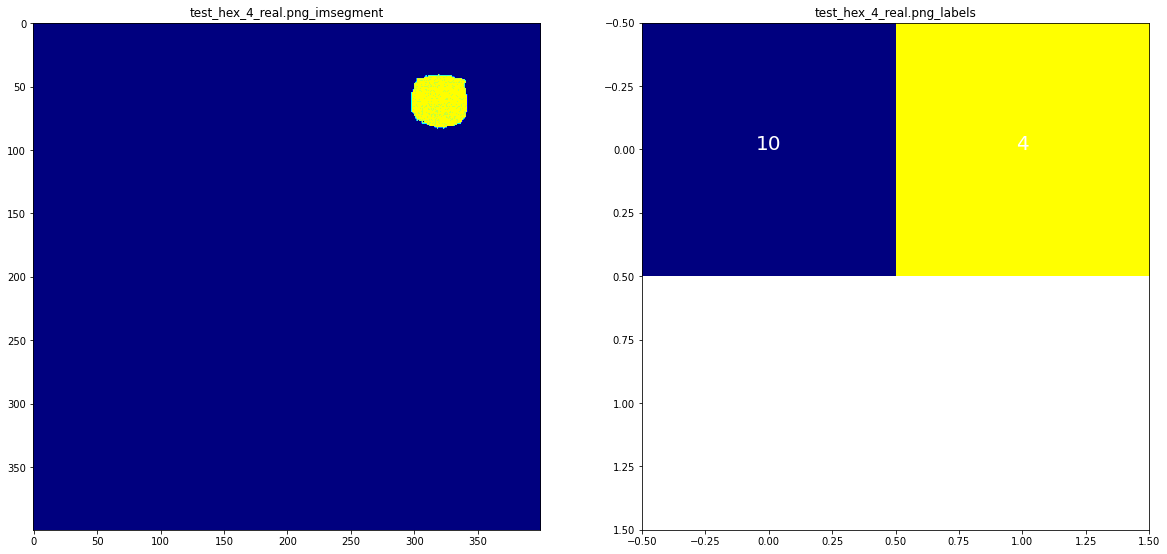

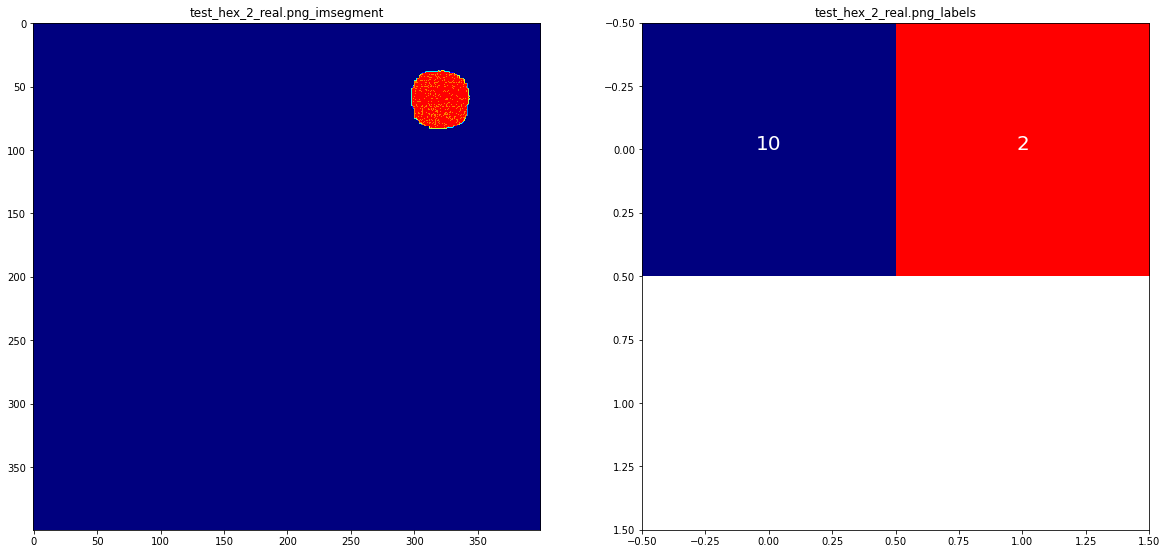

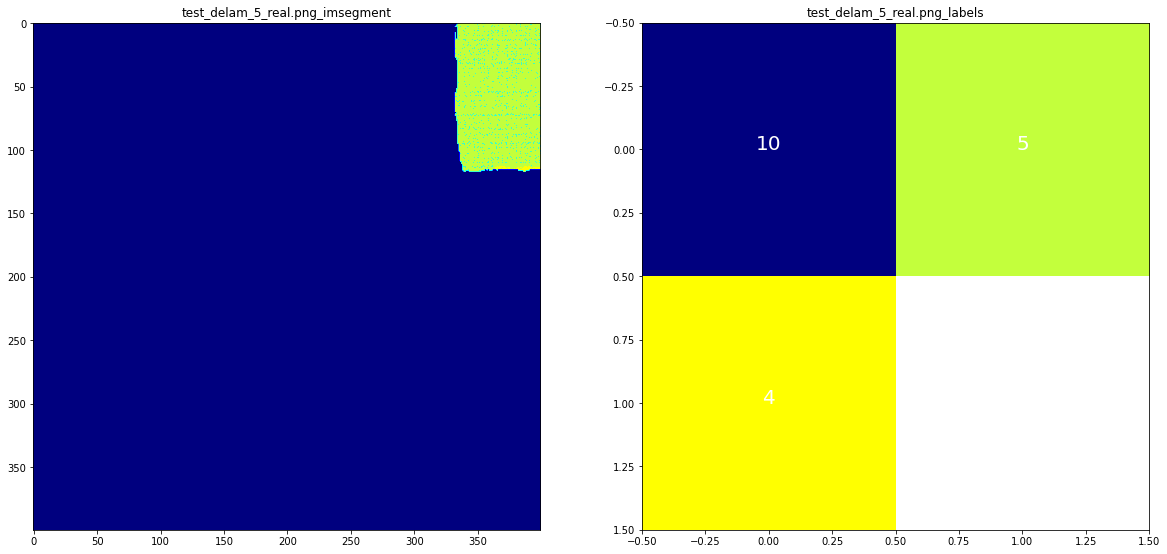

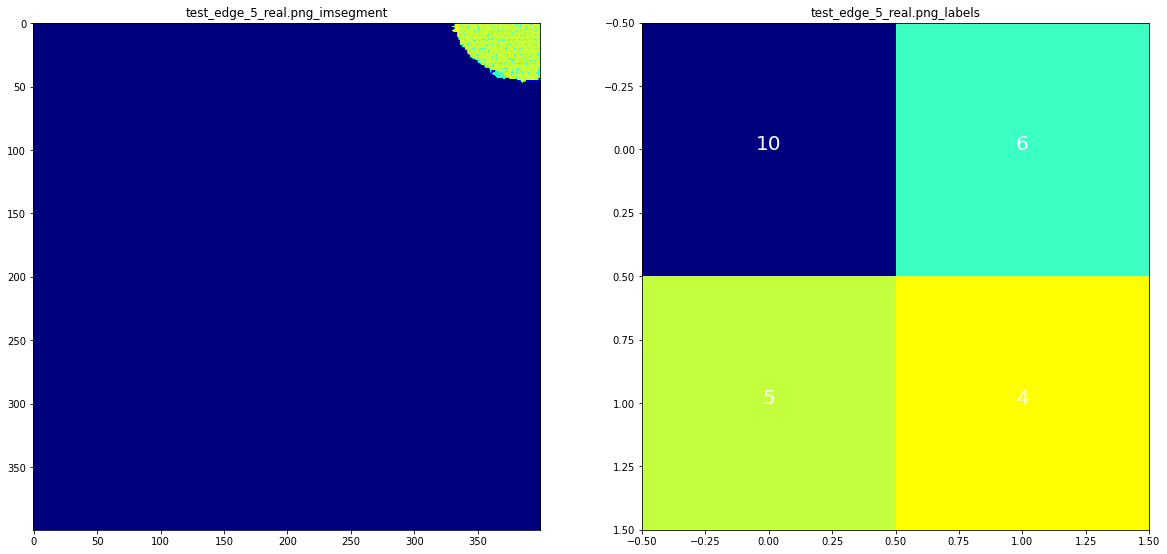

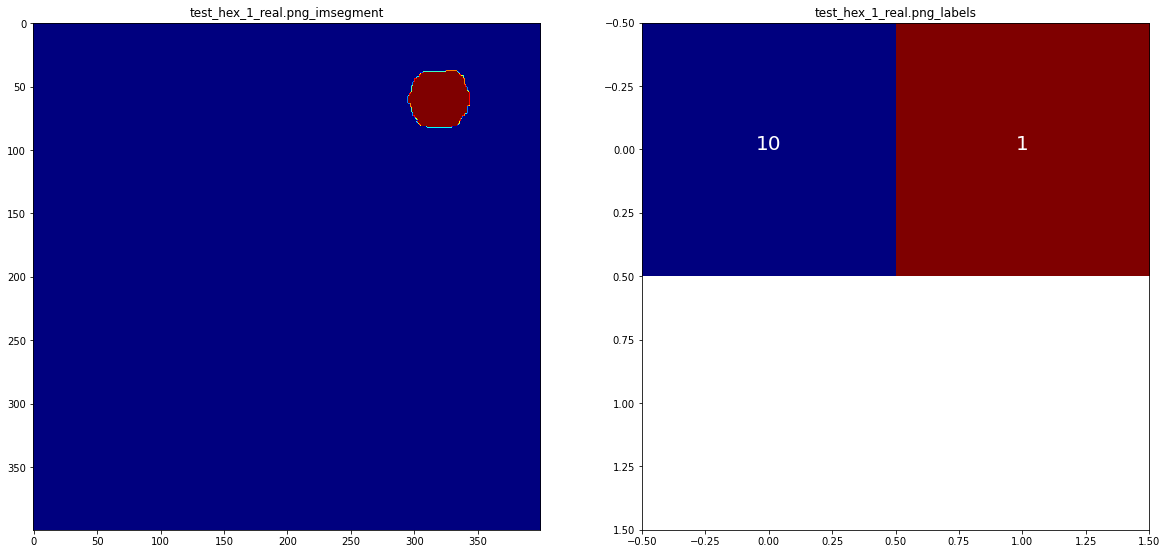

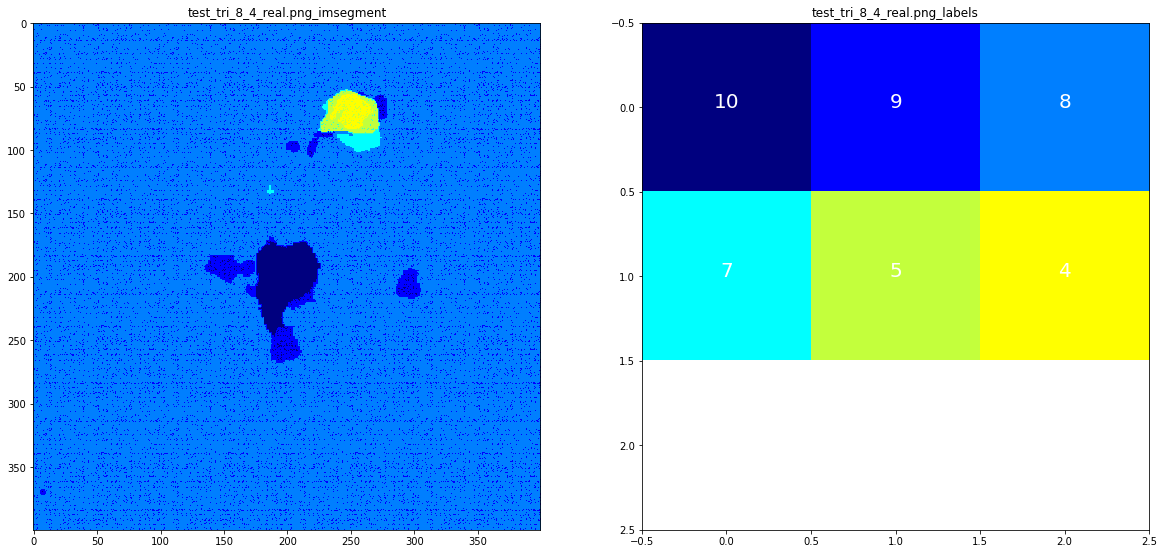

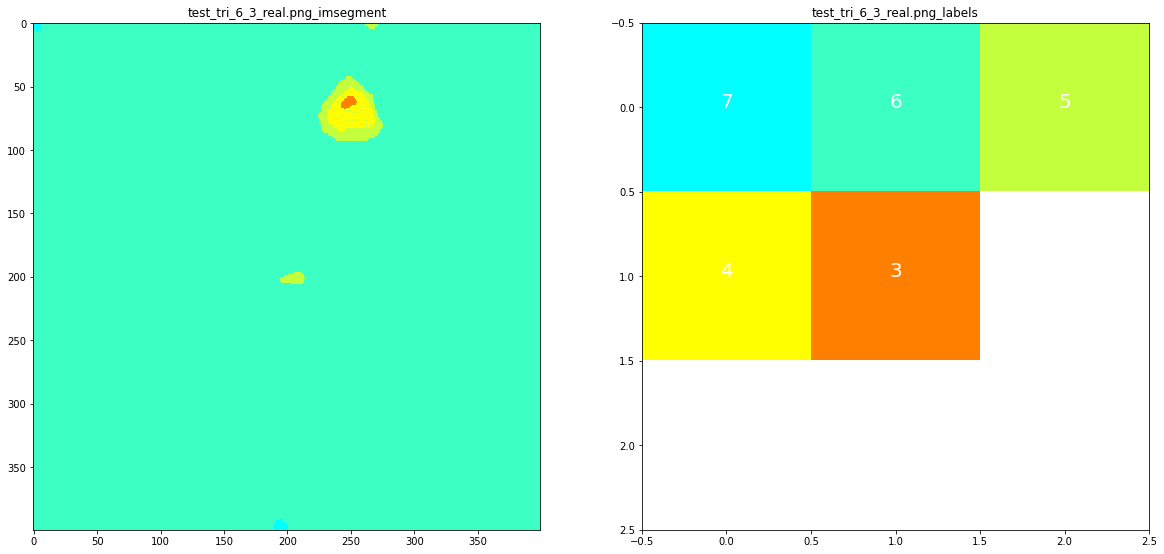

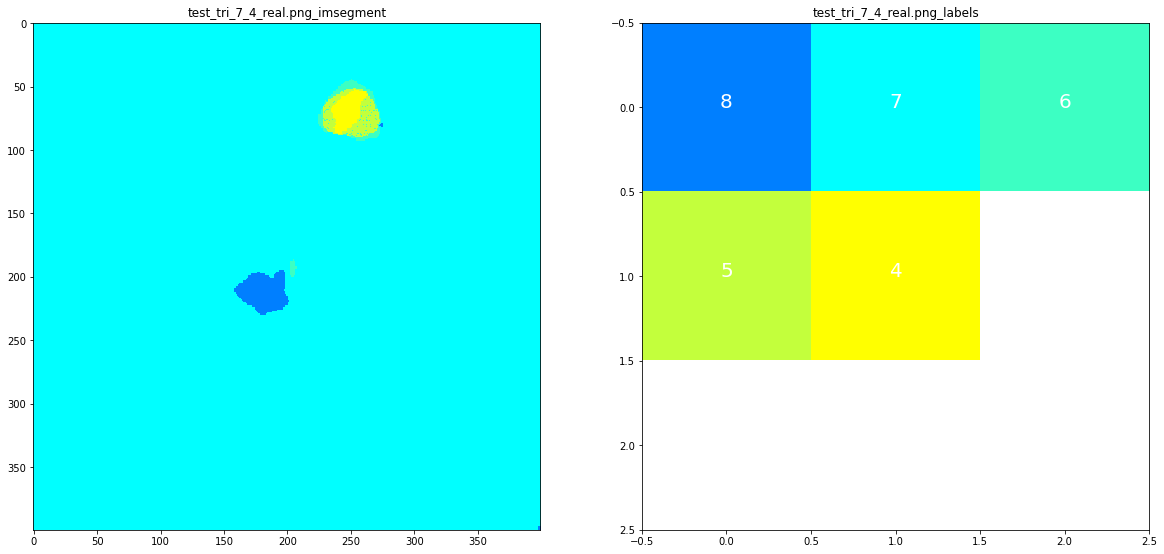

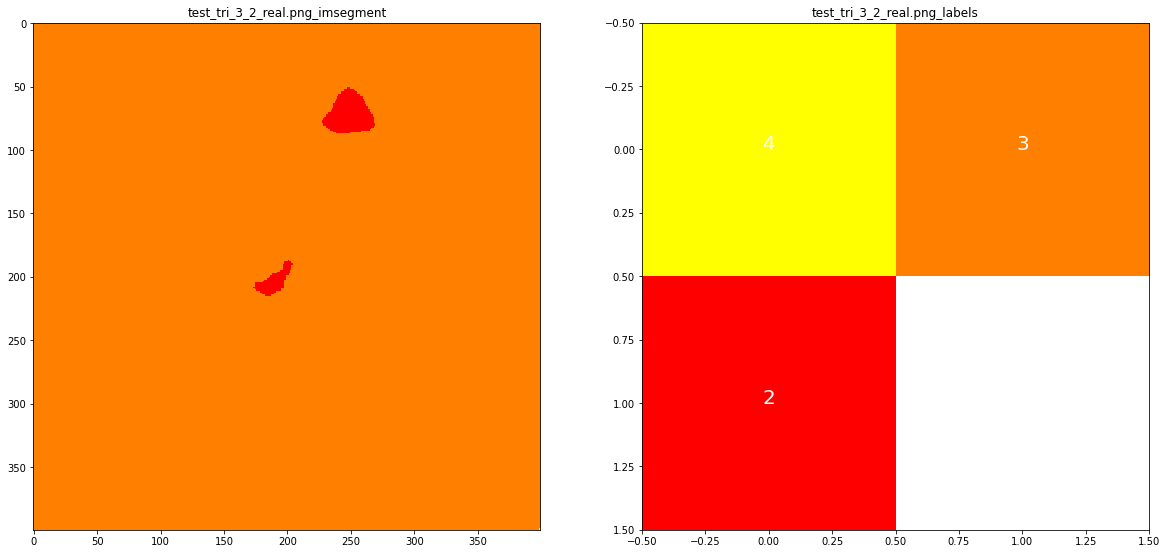

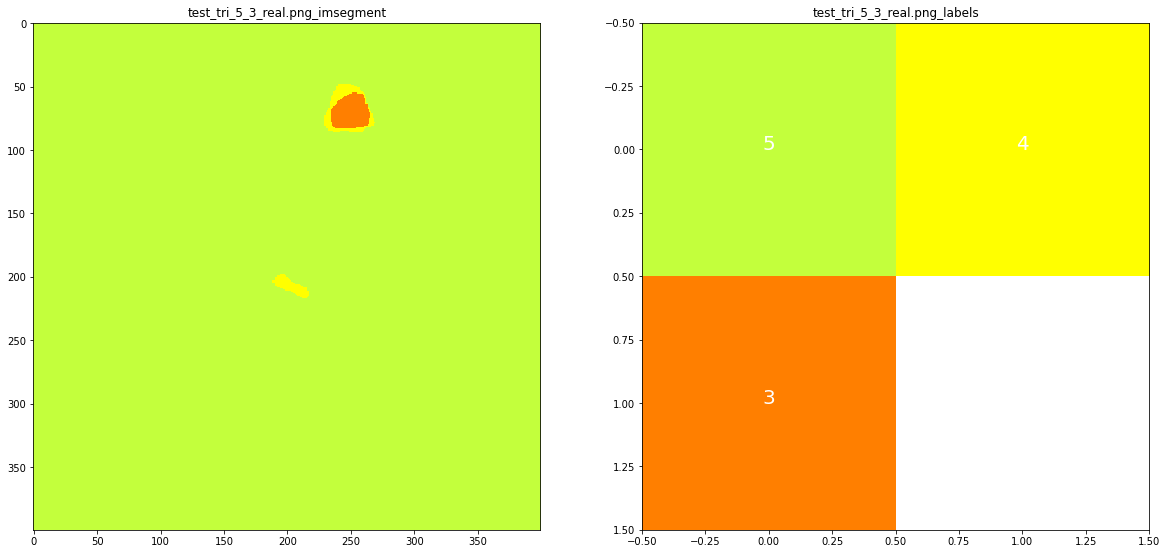

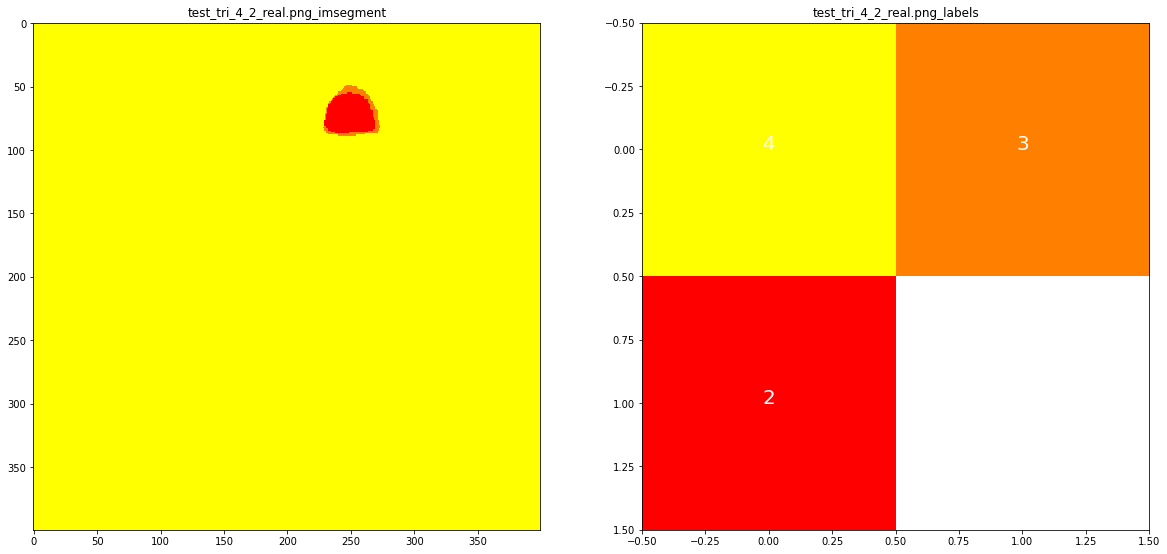

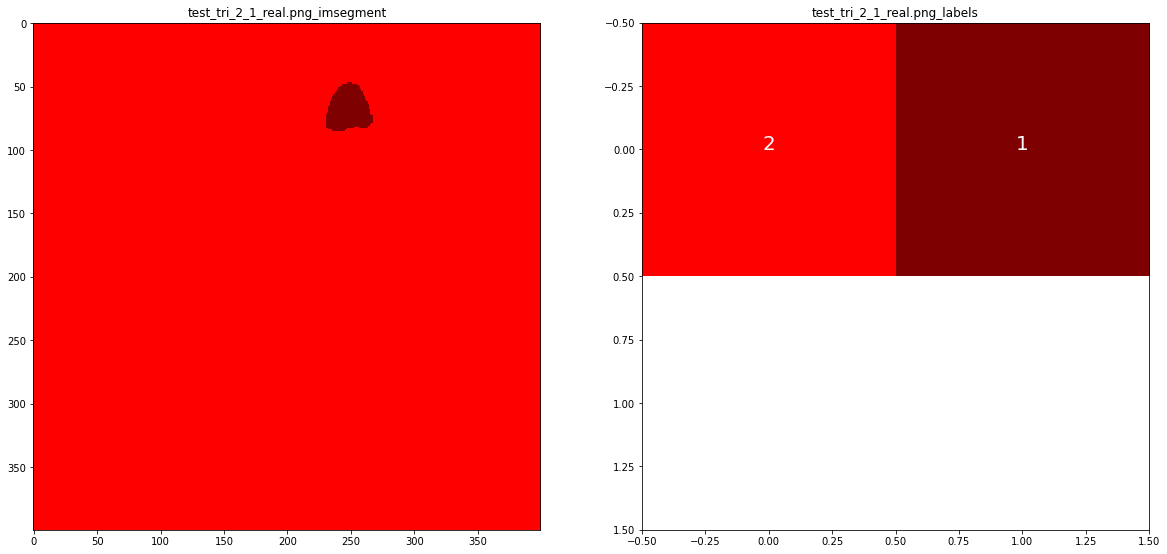

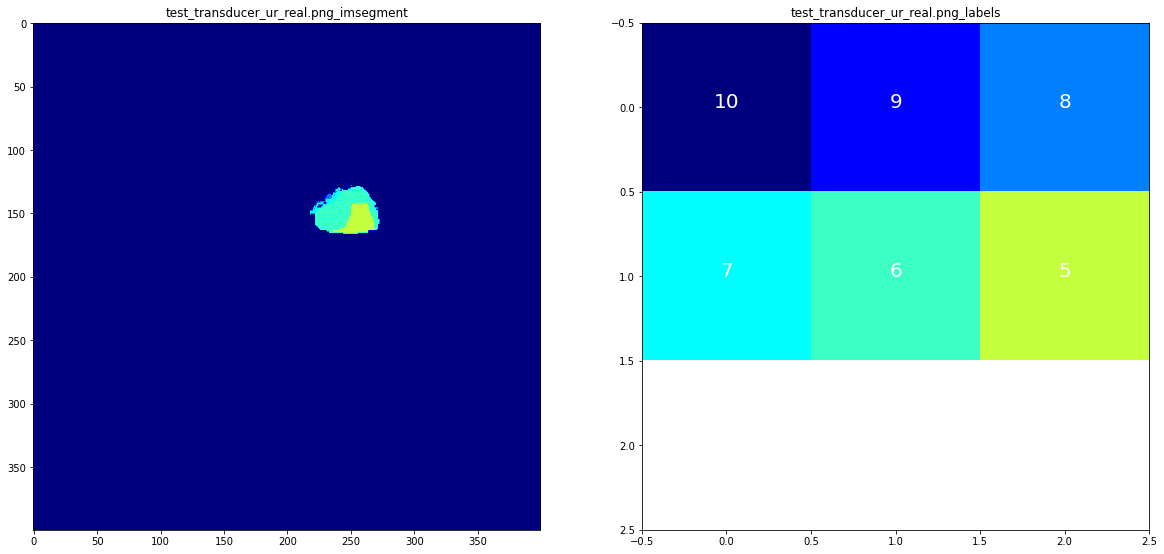

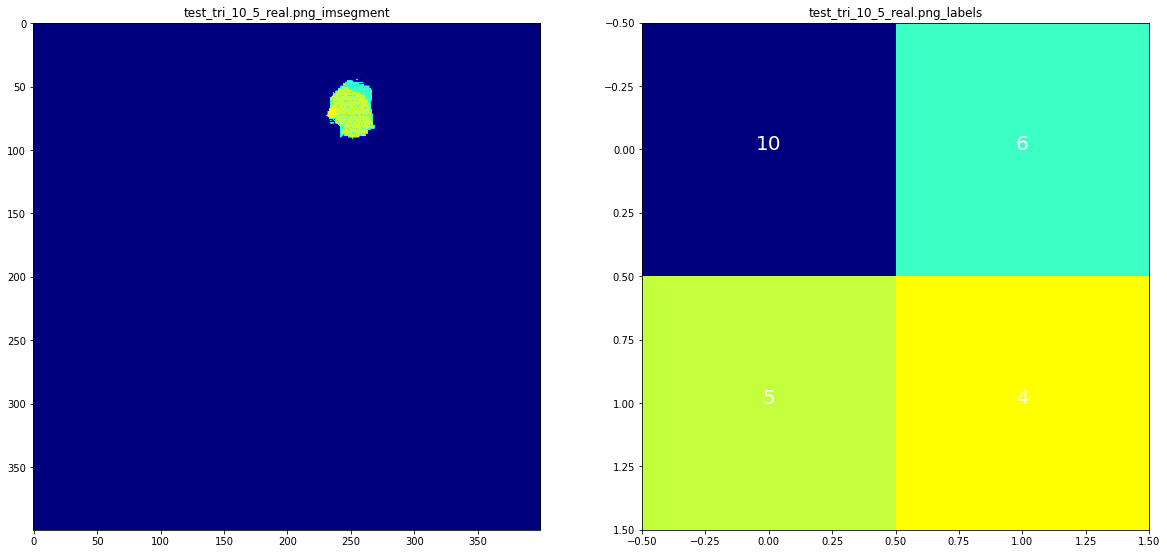

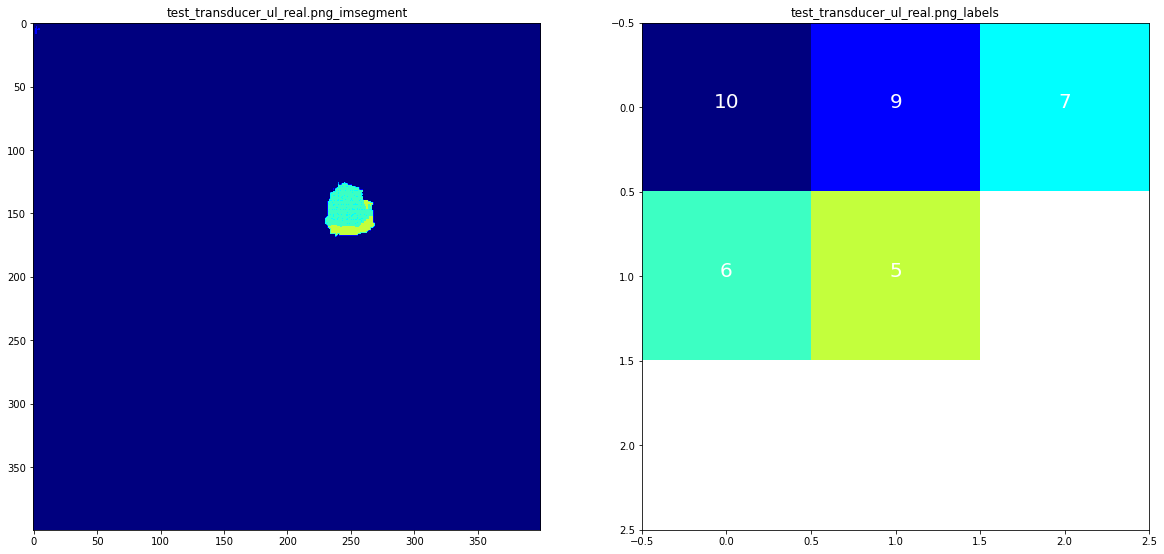

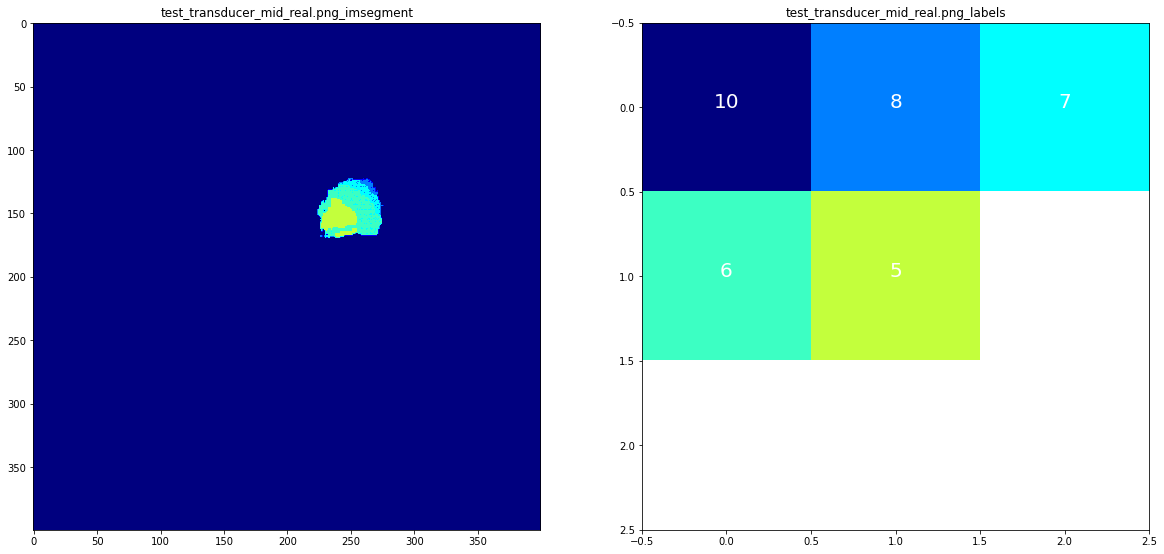

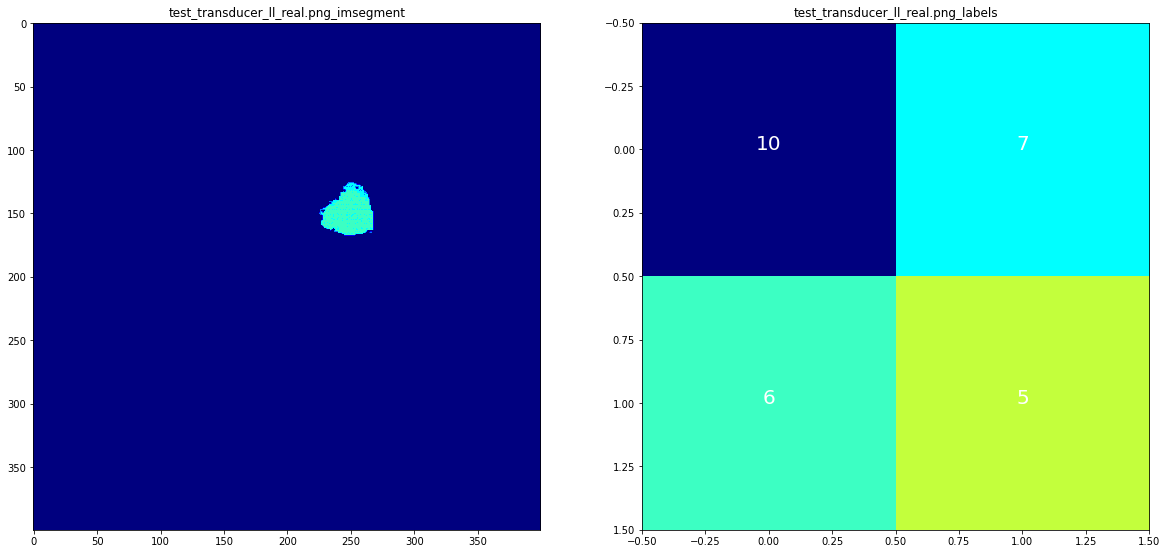

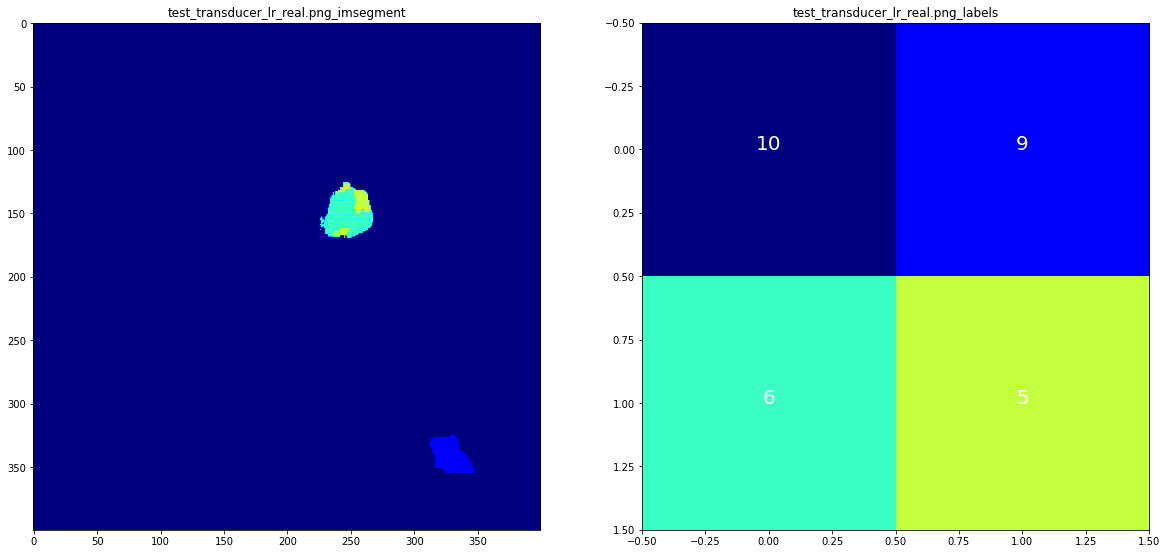

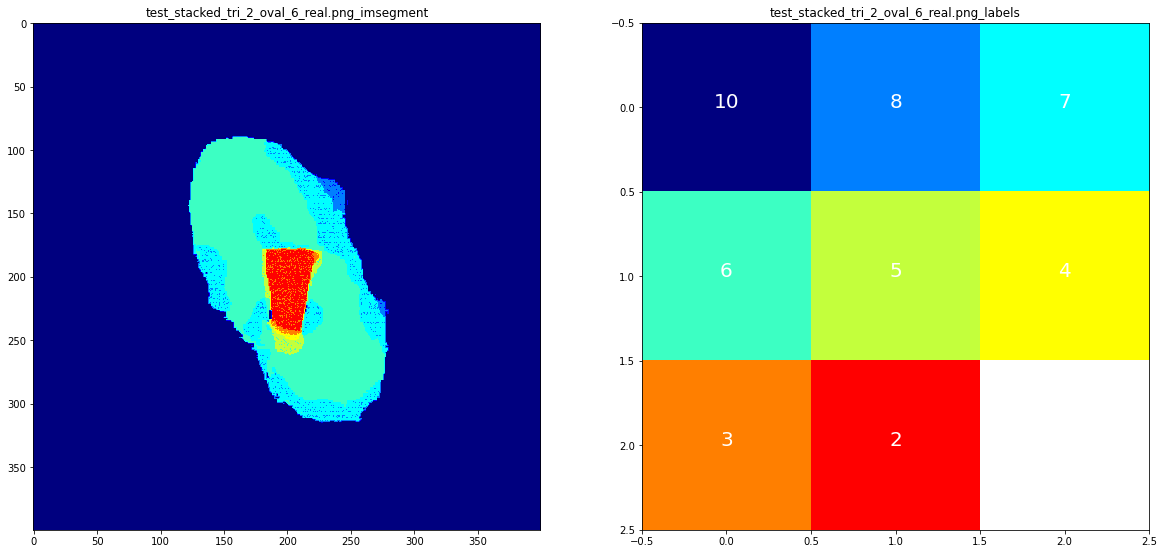

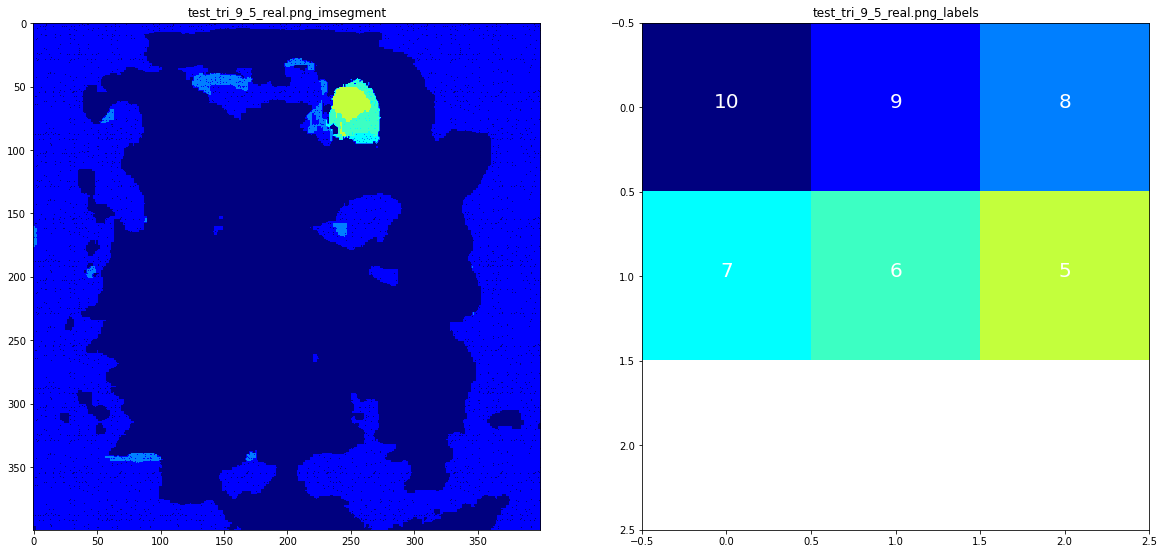

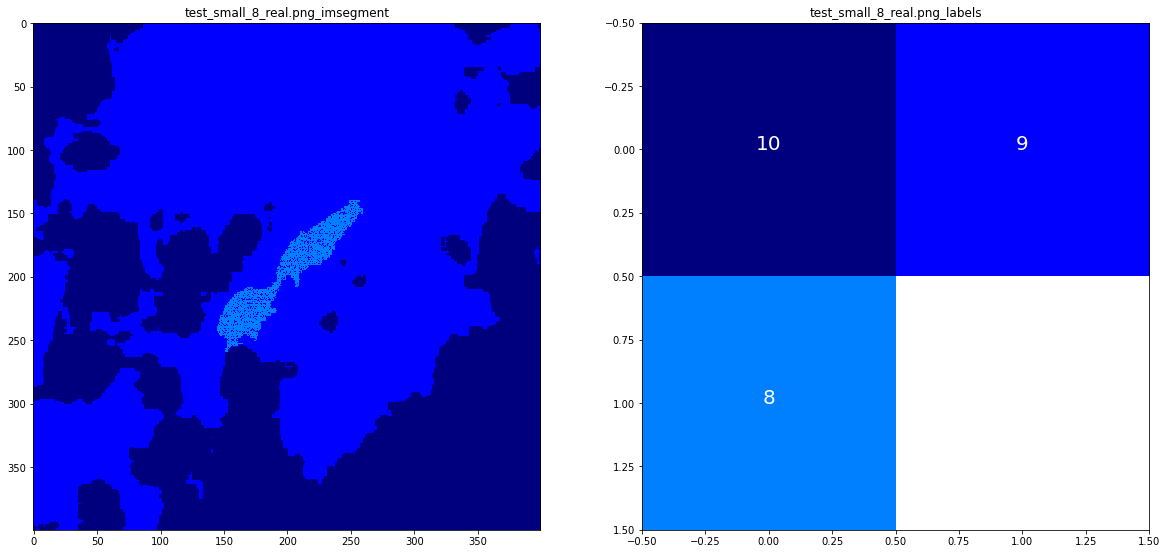

In [ ]:
# Get predicitons for the test set at once
testimg = get_image_files(path_test)
for filename in testimg:
    test_img = open_image(filename)
    # Show single prediction
    pred = learn.predict(test_img)
    # Show segmentation interpretation grid with titles
    interp._interp_show(pred[0],classes,title_suffix=filename.name,cmap=cmap,norm=norm)

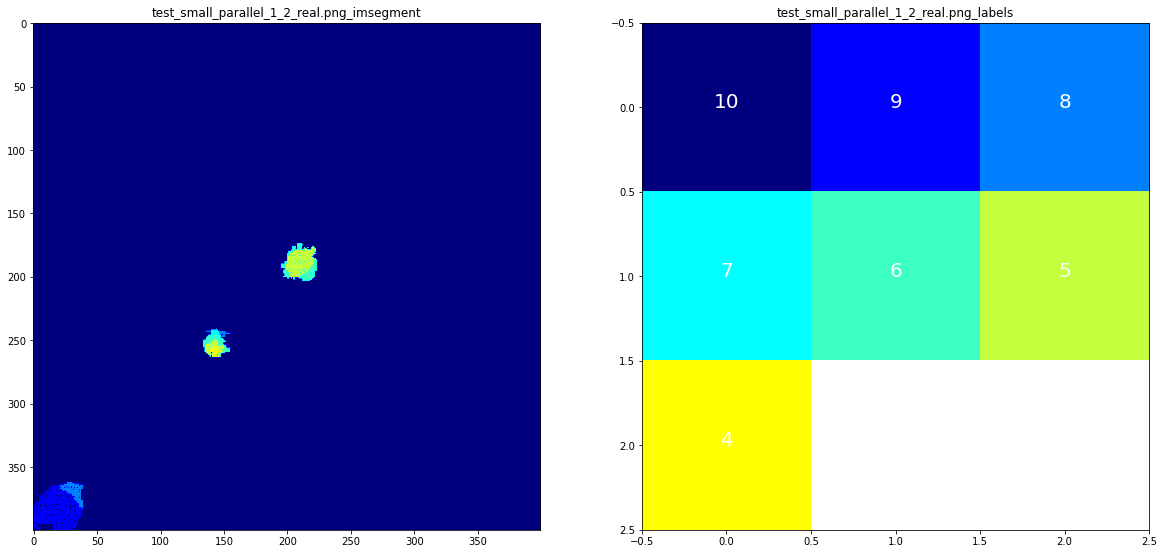

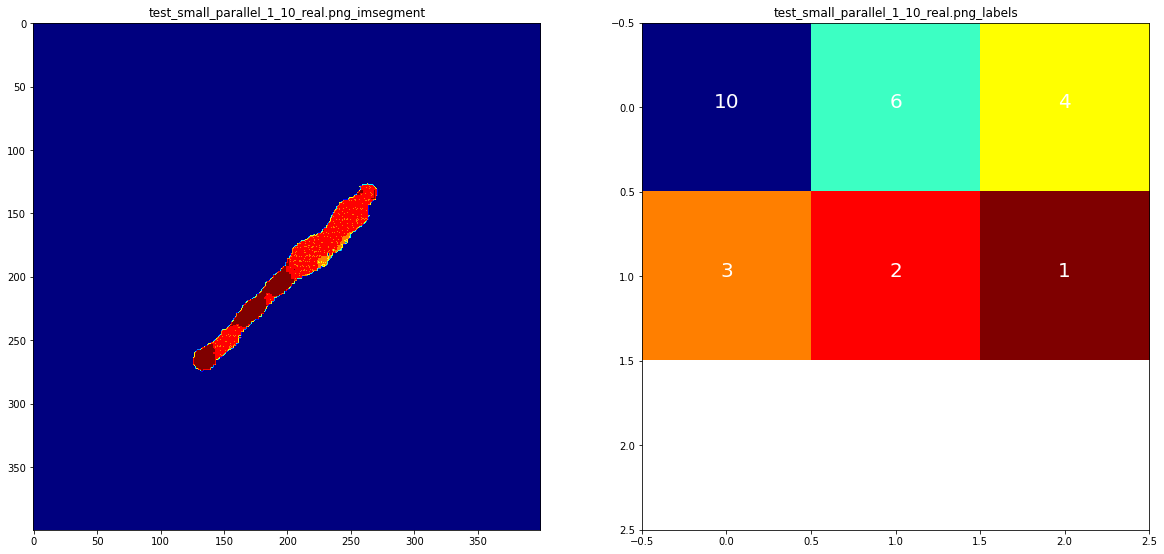

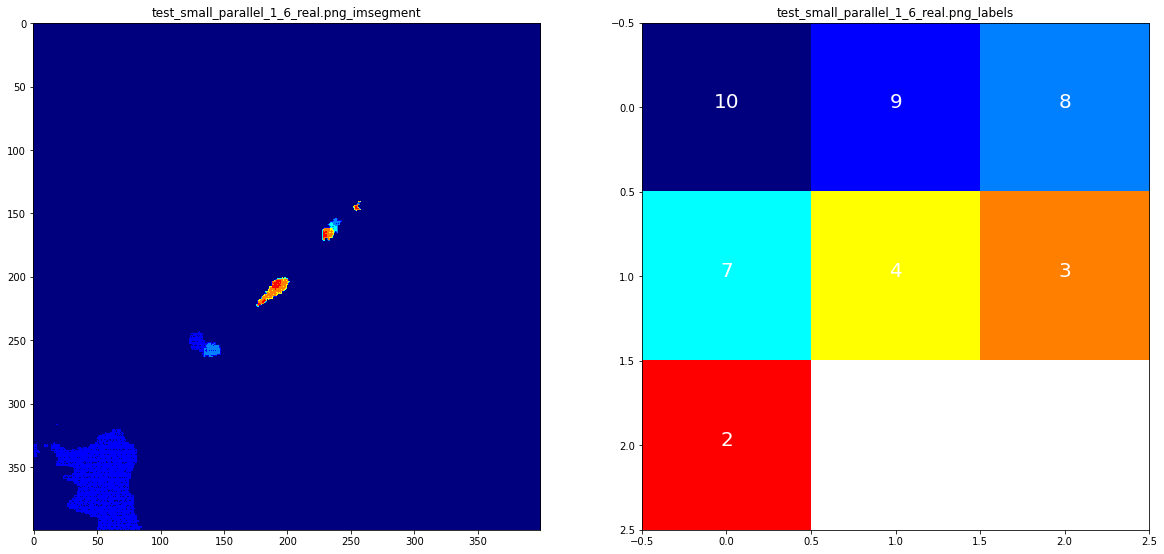

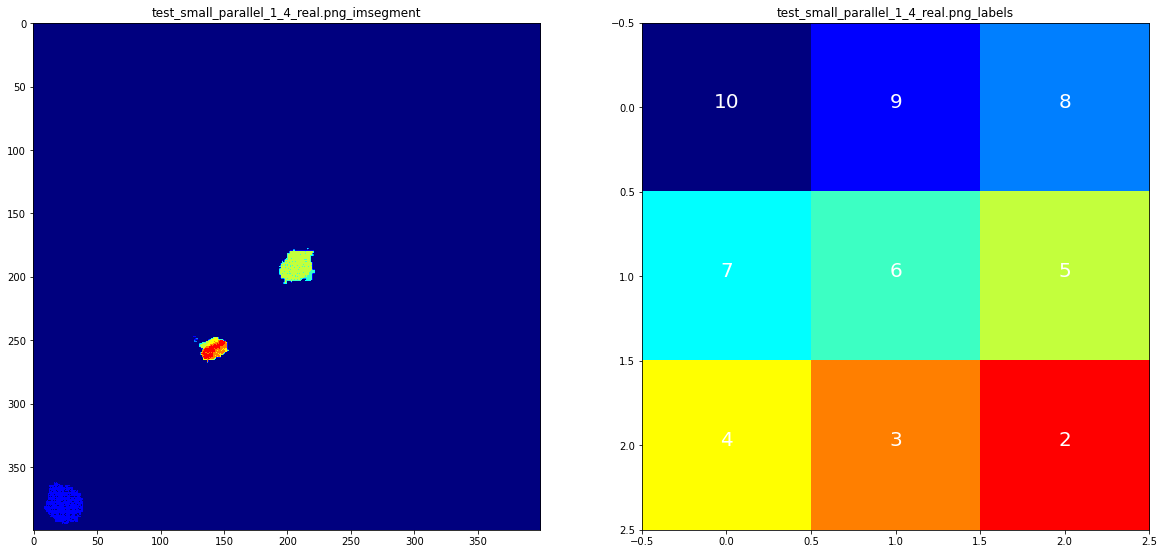

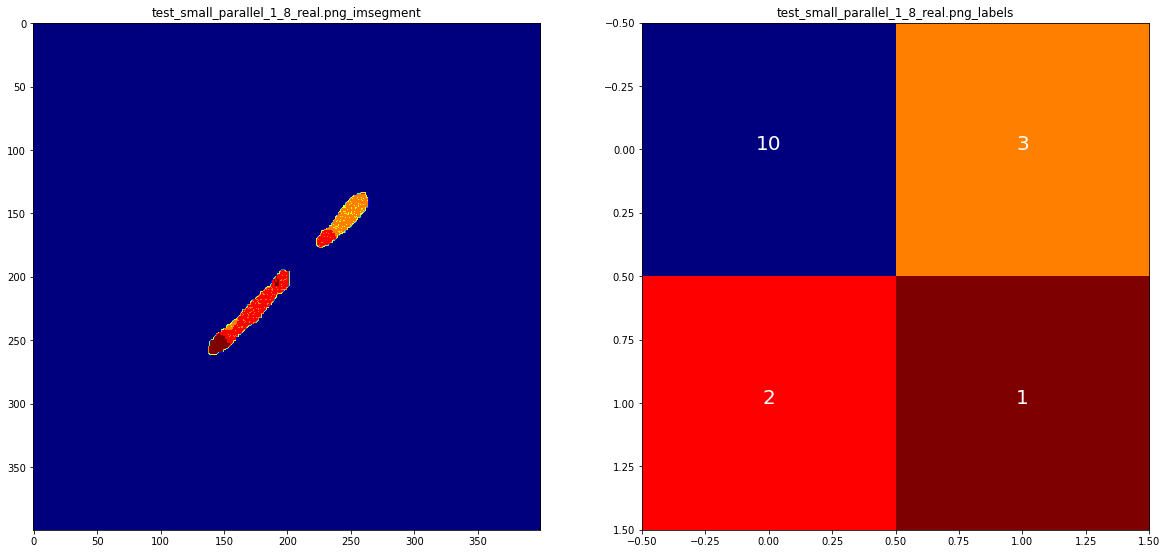

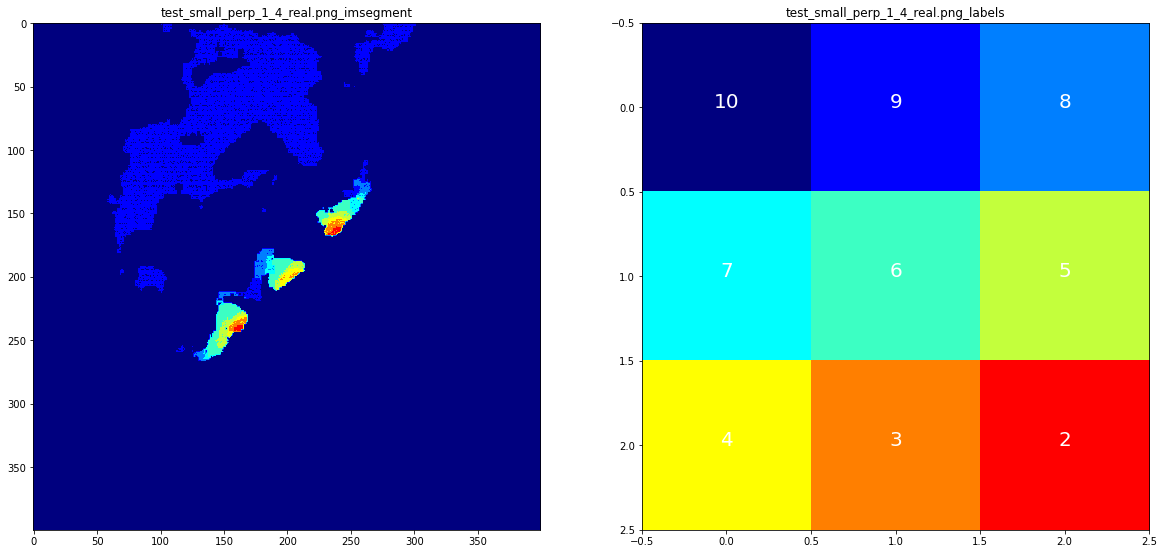

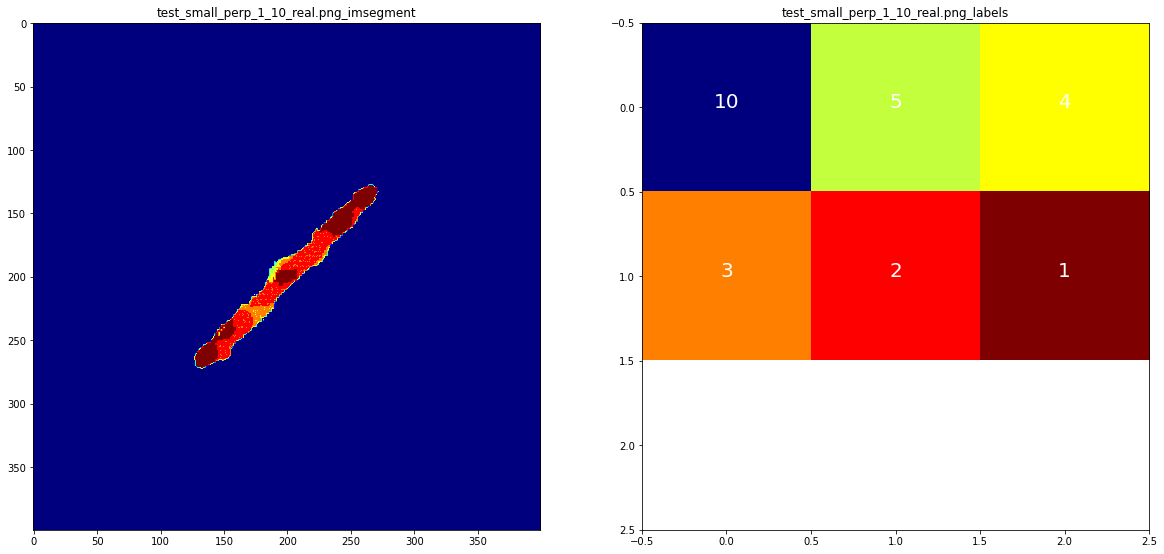

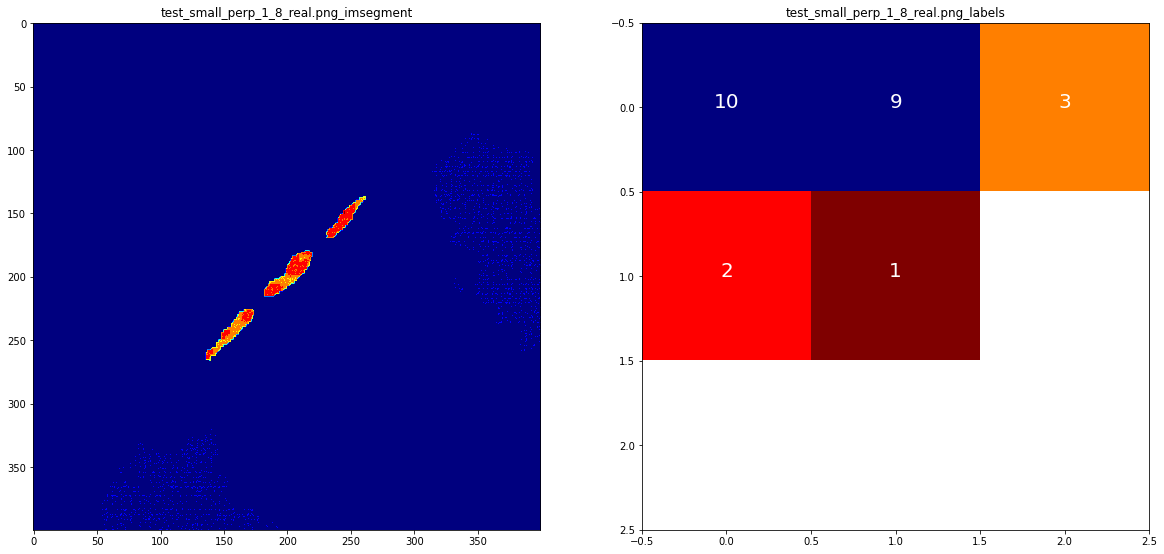

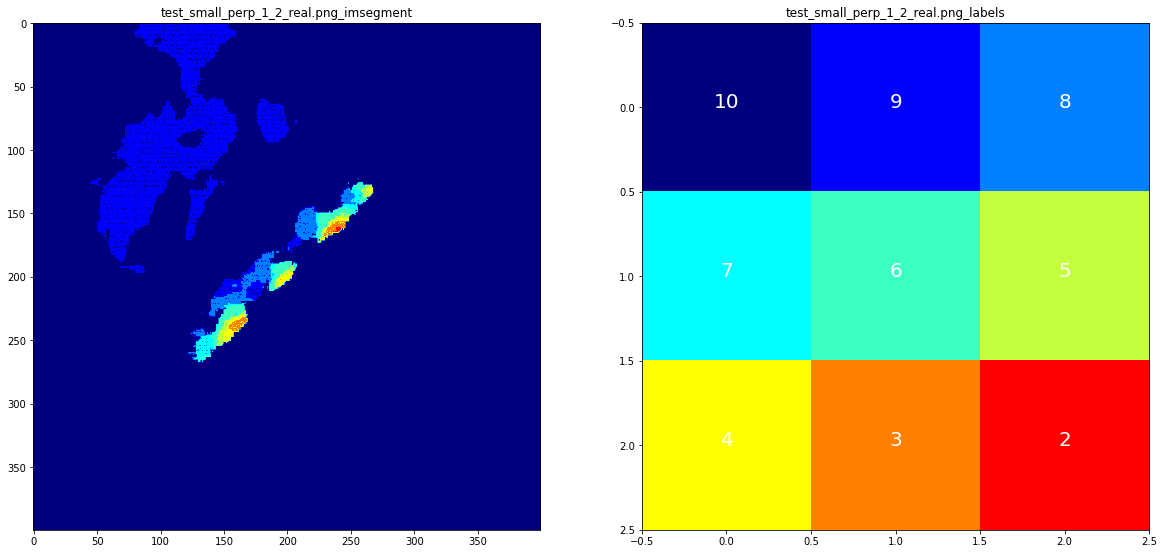

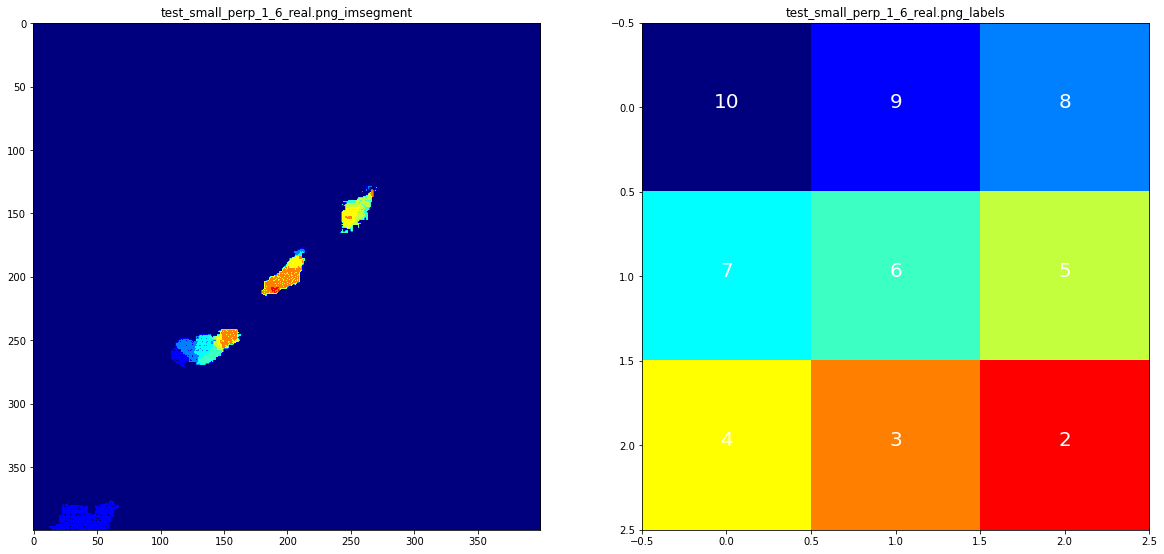

In [ ]:
# Get predicitons for the test set (small width defects) at once
testimg = get_image_files(test)
for filename in testimg:
    test_img = open_image(filename)
    # Show single prediction
    pred = learn.predict(test_img)
    # Show segmentation interpretation grid with titles
    interp._interp_show(pred[0],classes,title_suffix=filename.name,cmap=cmap,norm=norm)

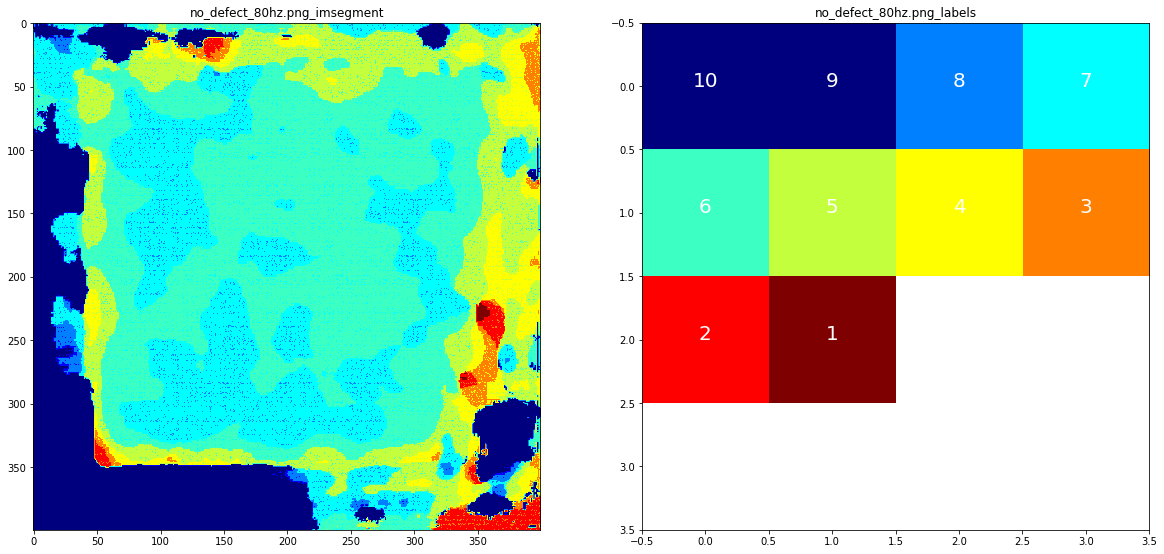

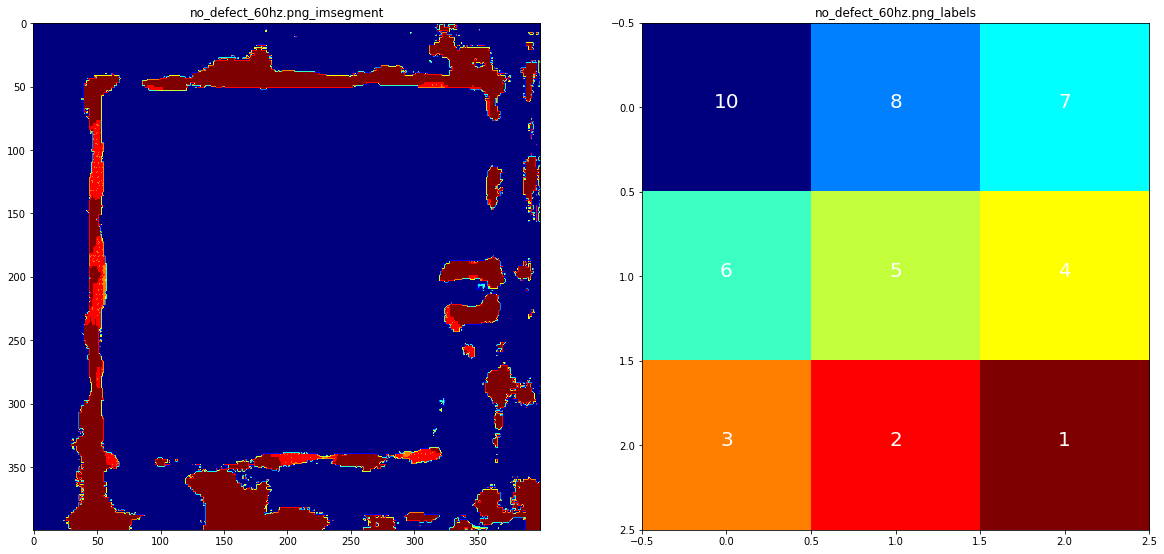

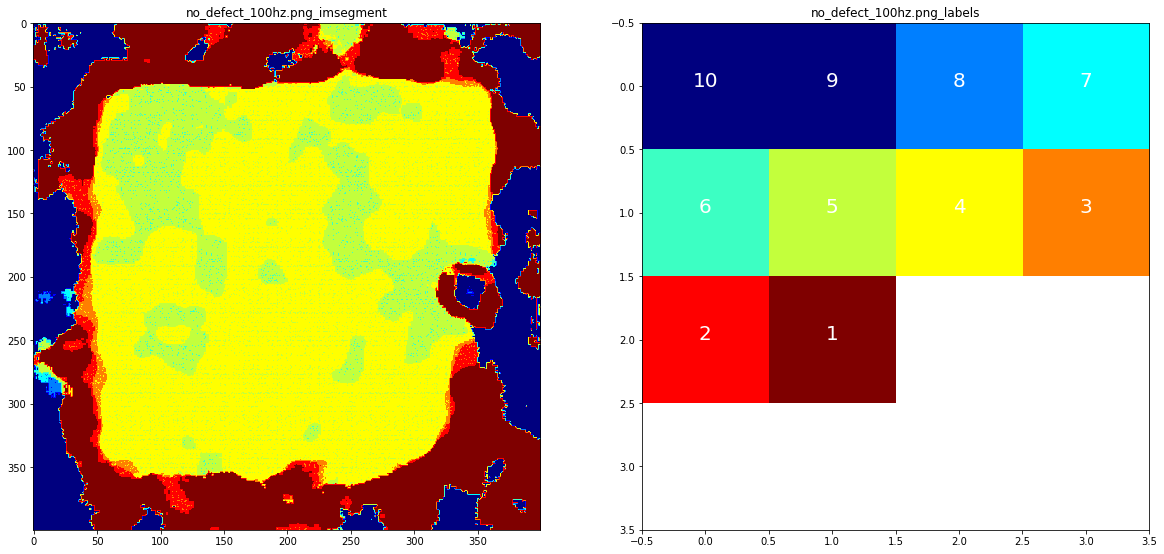

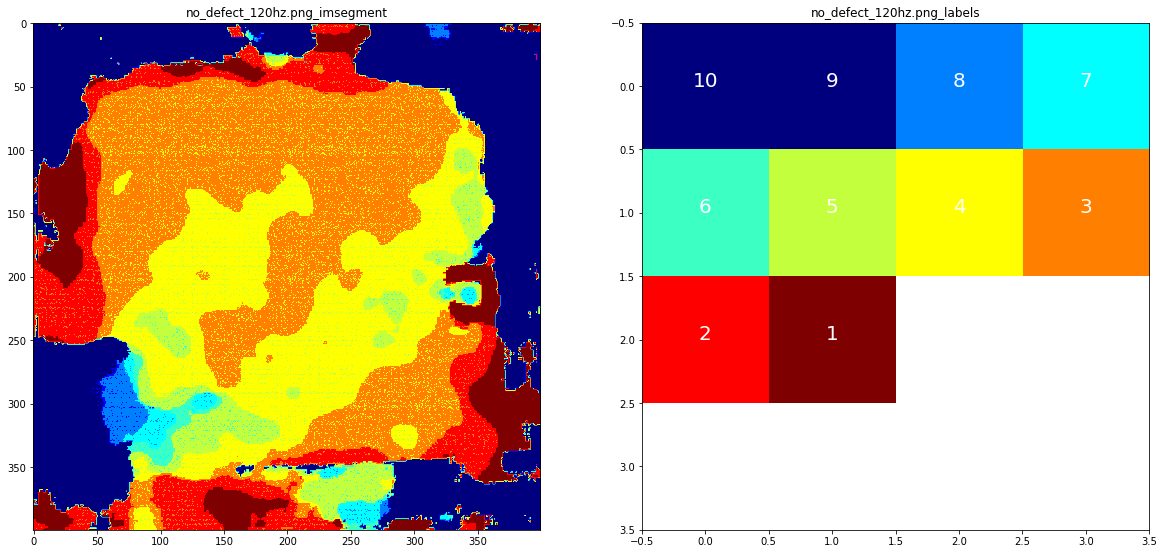

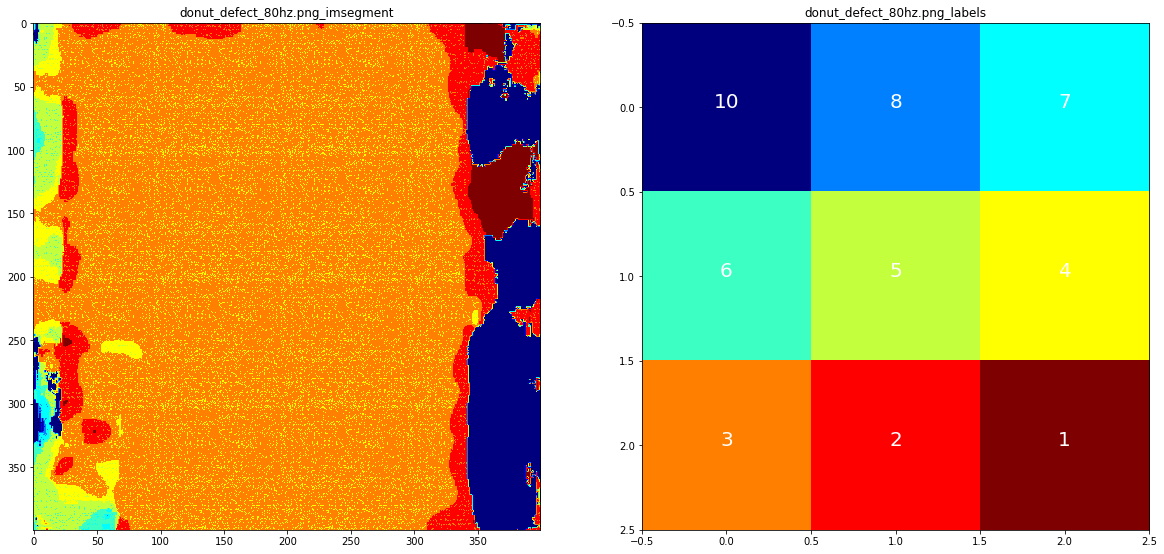

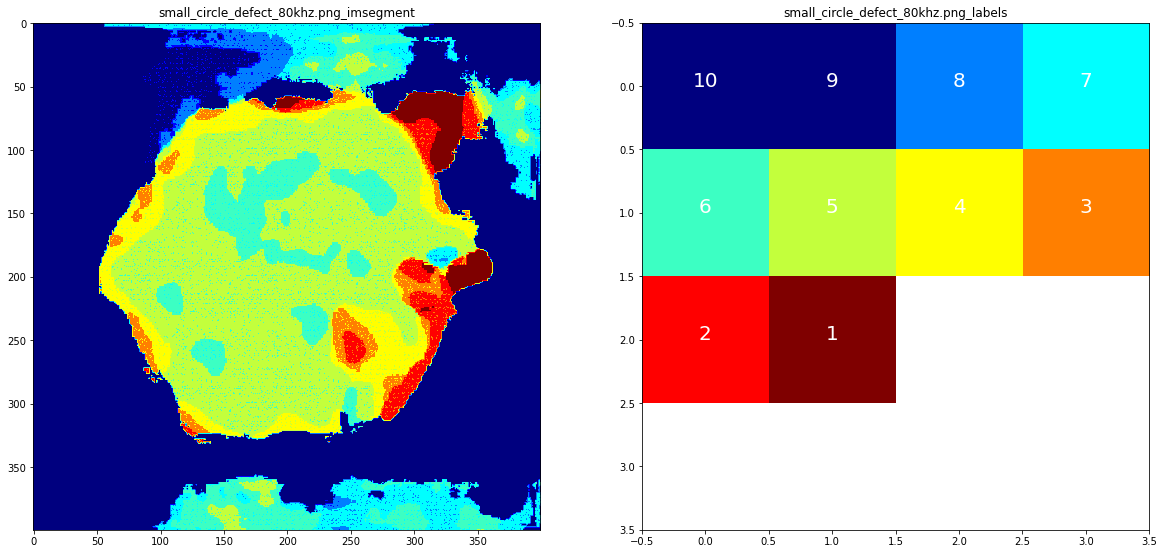

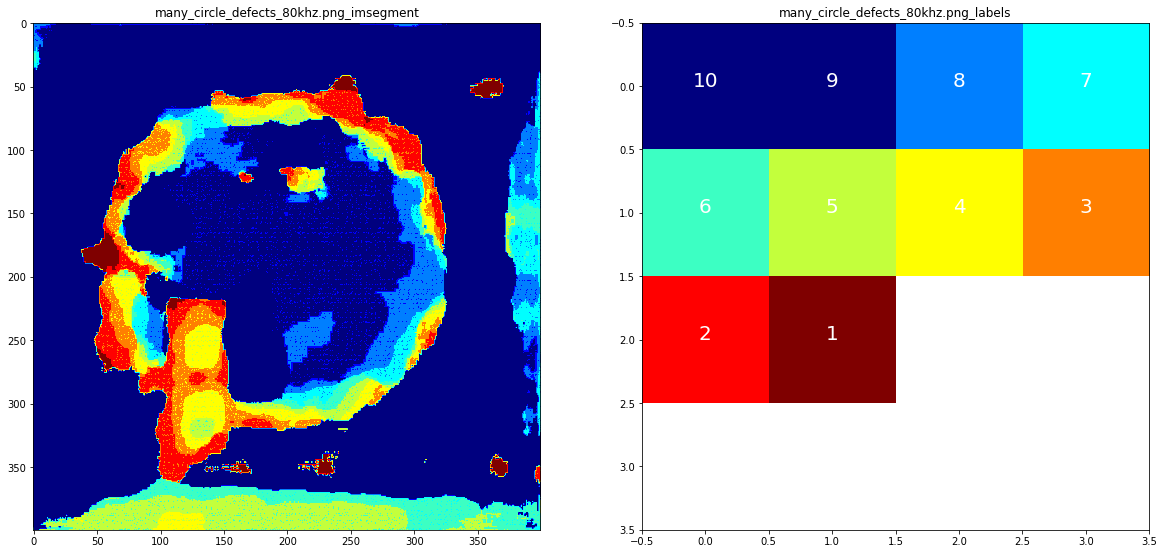

In [ ]:
# Get predicitons for the experimental data at once
testimg = get_image_files(exp)
for filename in testimg:
    test_img = open_image(filename)
    # Show single prediction
    pred = learn.predict(test_img)
    # Show segmentation interpretation grid with titles
    interp._interp_show(pred[0],classes,title_suffix=filename.name,cmap=cmap,norm=norm)

The rest of the codes was for different Gaussian noise levels case study.

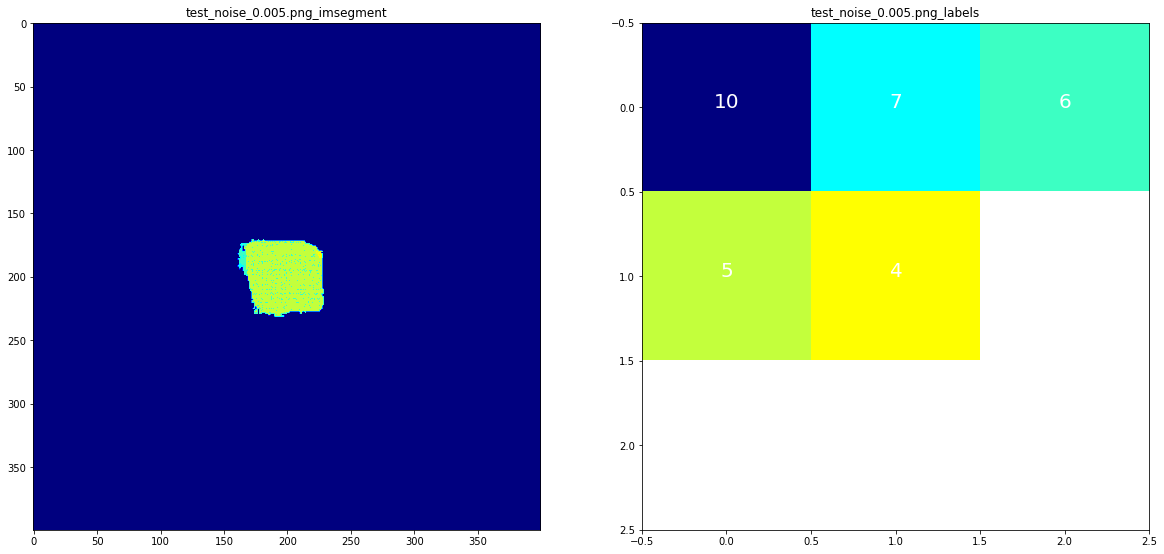

In [ ]:
# Case study: Gaussian noise levels
# Save the noisy image in the noise folder
res = learn.predict(open_image(path_noise/'test_noise_0.005.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.005.png',cmap=cmap,norm=norm)

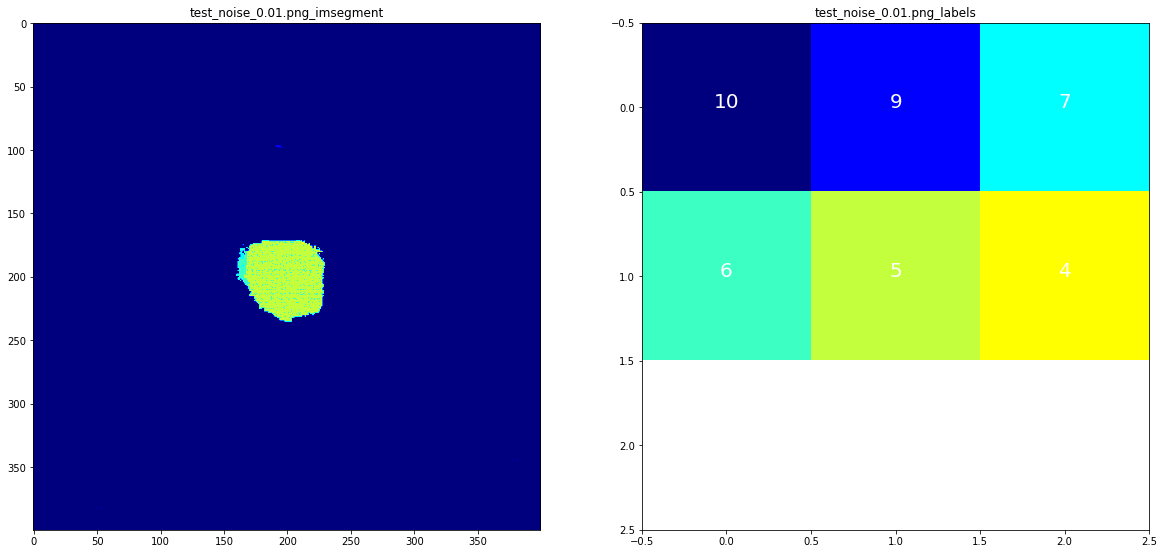

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.01.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.01.png',cmap=cmap,norm=norm)

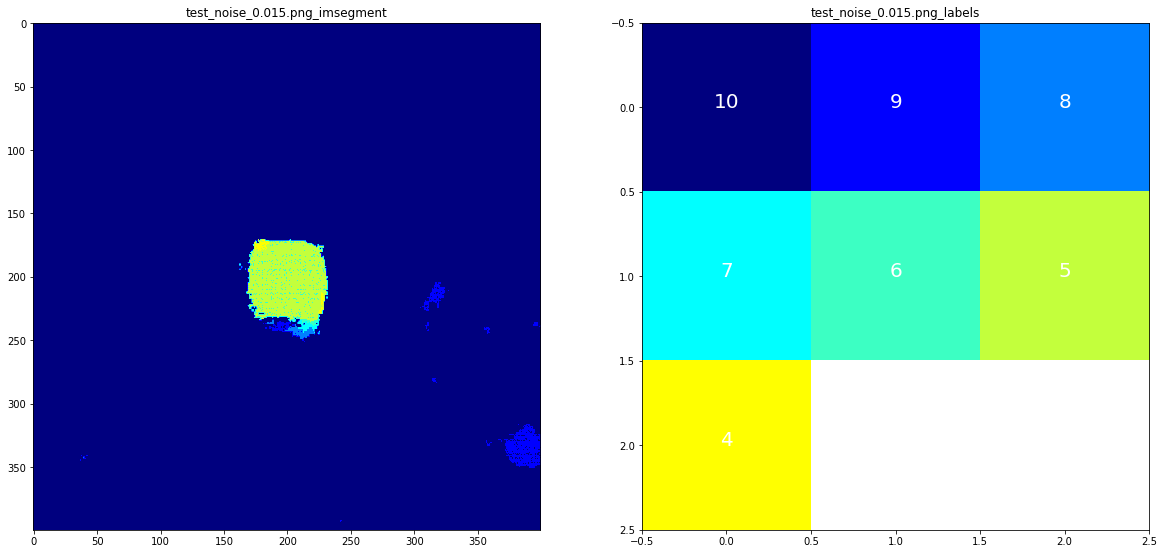

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.015.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.015.png',cmap=cmap,norm=norm)

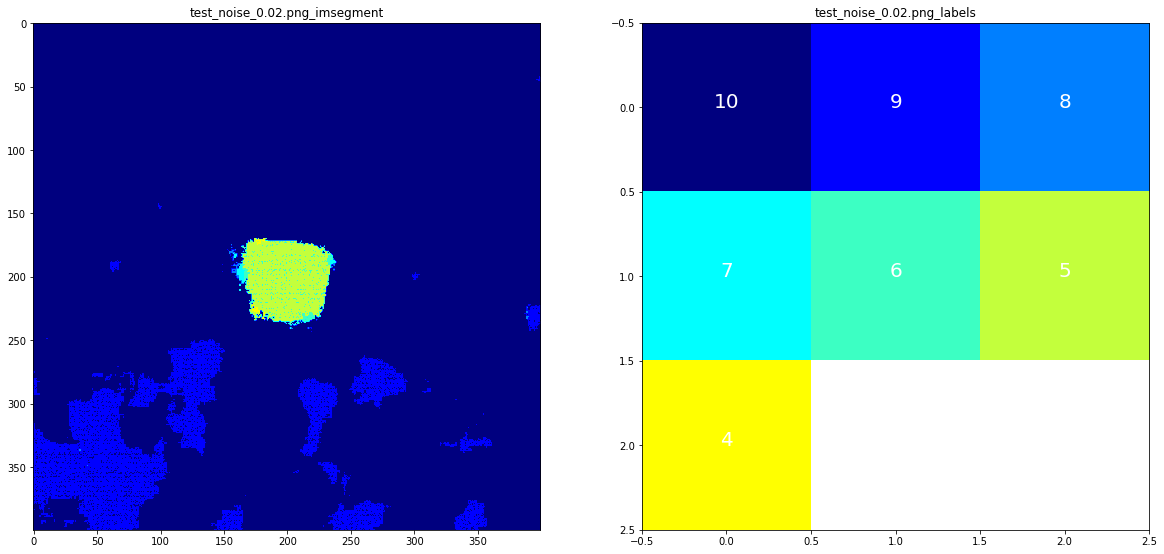

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.02.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.02.png',cmap=cmap,norm=norm)

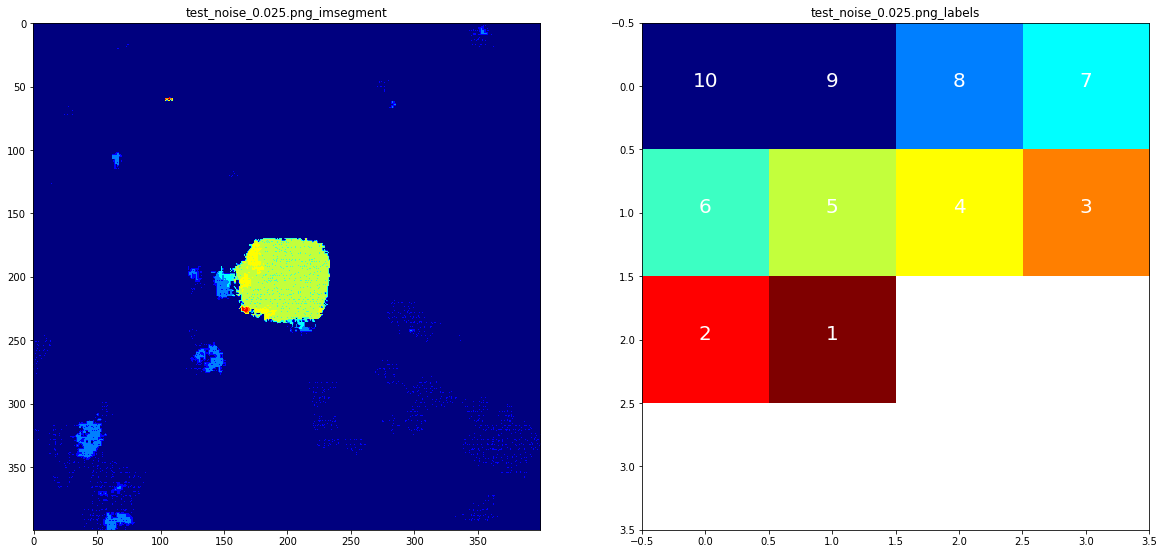

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.025.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.025.png',cmap=cmap,norm=norm)

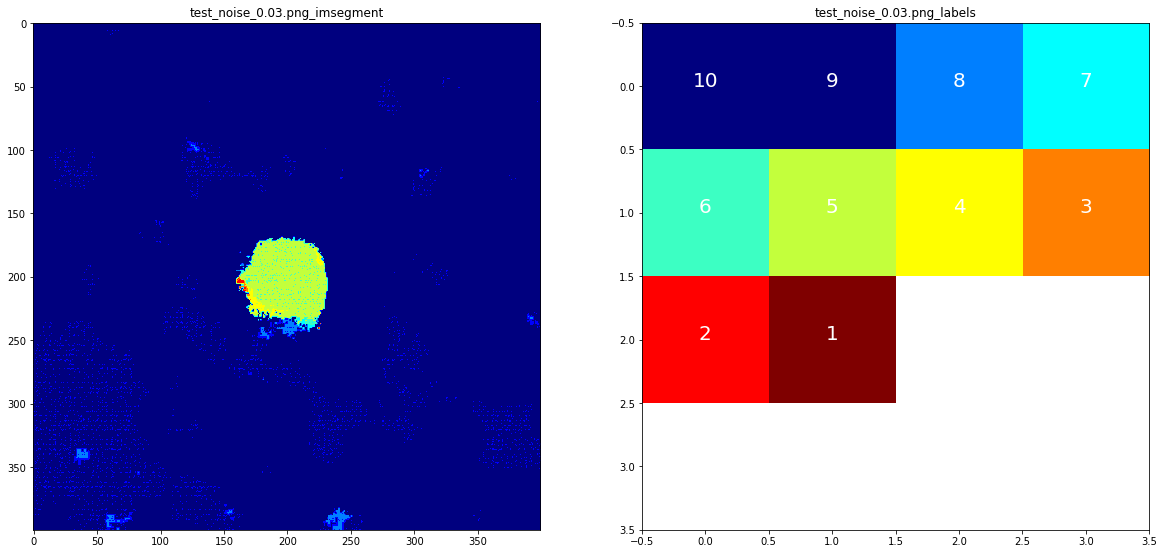

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.03.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.03.png',cmap=cmap,norm=norm)

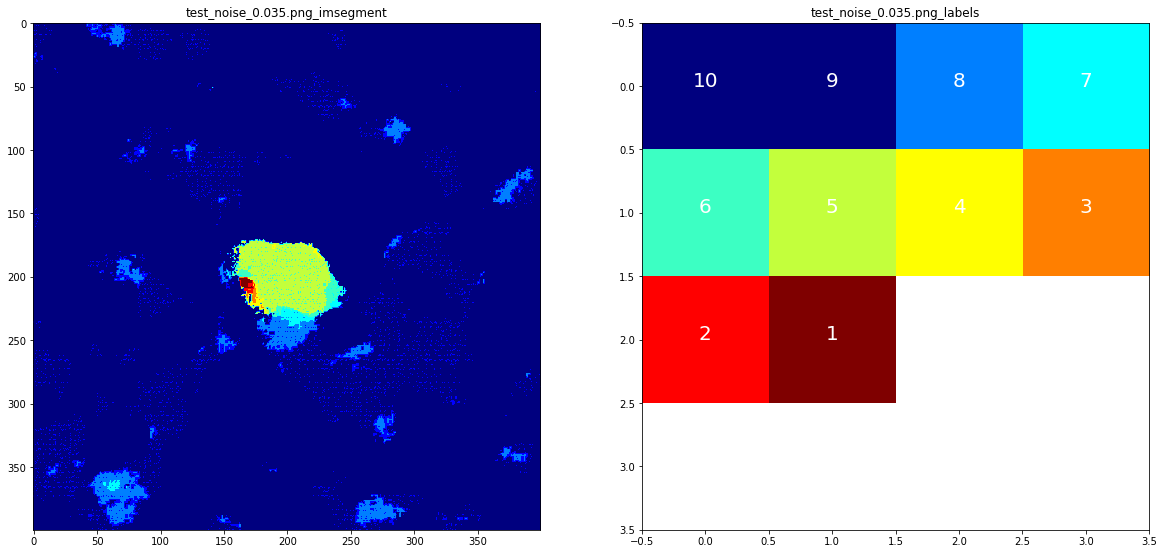

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.035.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.035.png',cmap=cmap,norm=norm)

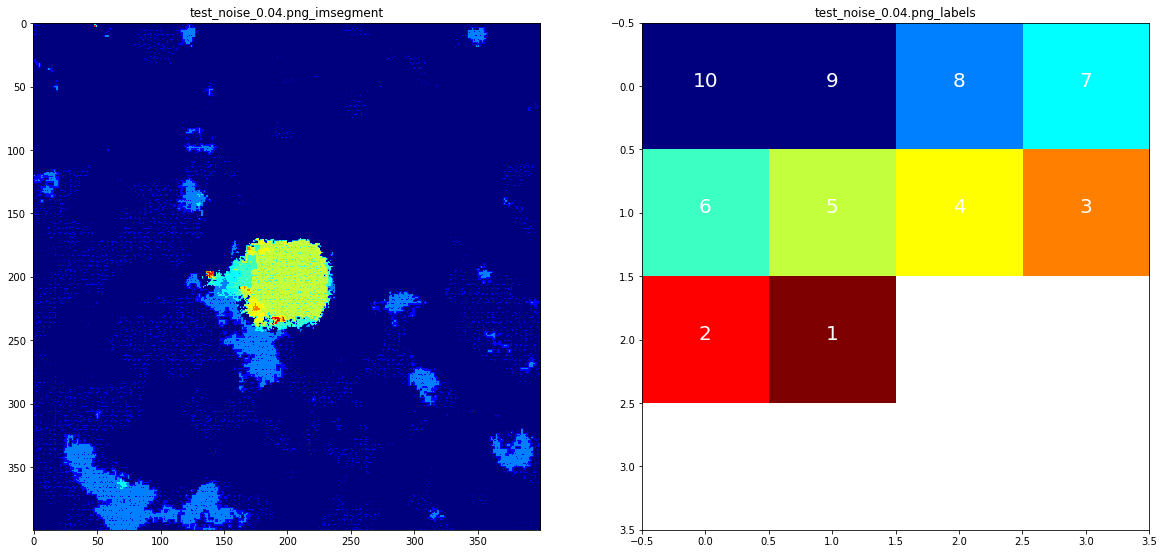

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.04.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.04.png',cmap=cmap,norm=norm)

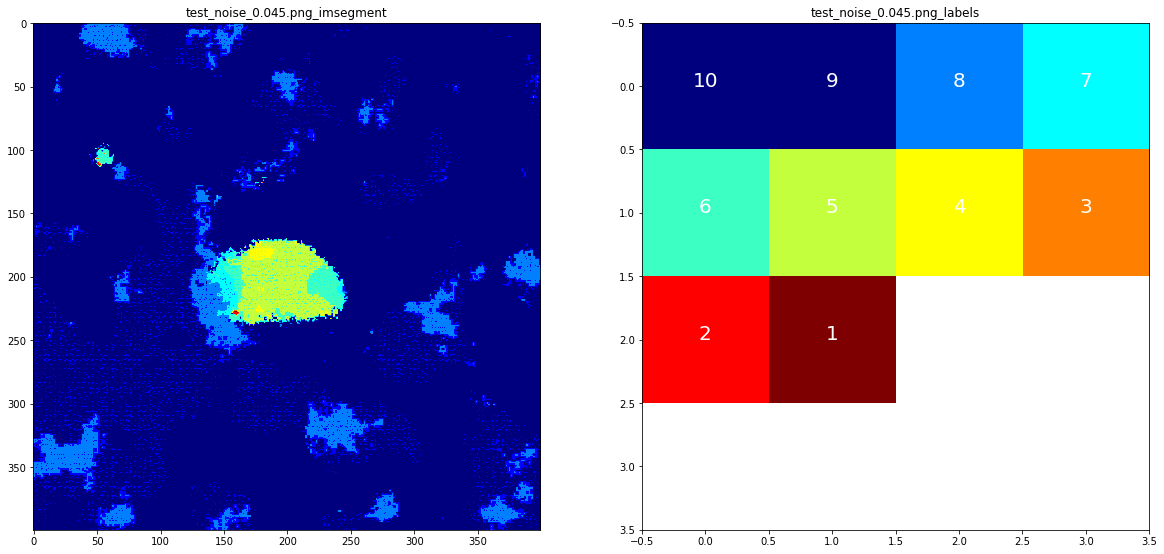

In [ ]:
res = learn.predict(open_image(path_noise/'test_noise_0.045.png'))
interp._interp_show(res[0],classes,title_suffix='test_noise_0.045.png',cmap=cmap,norm=norm)

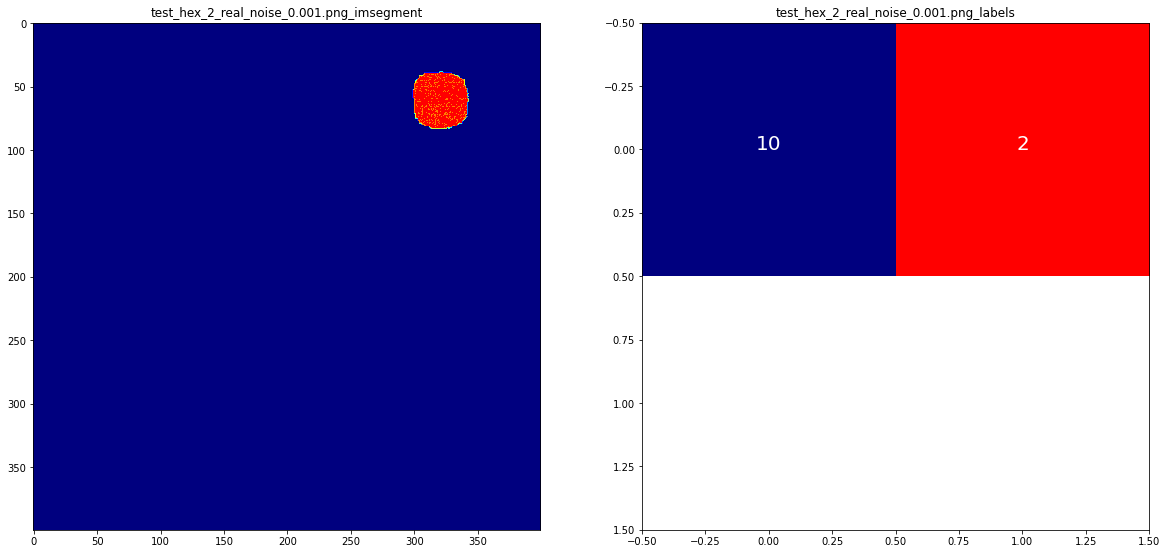

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.001.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.001.png',cmap=cmap,norm=norm)

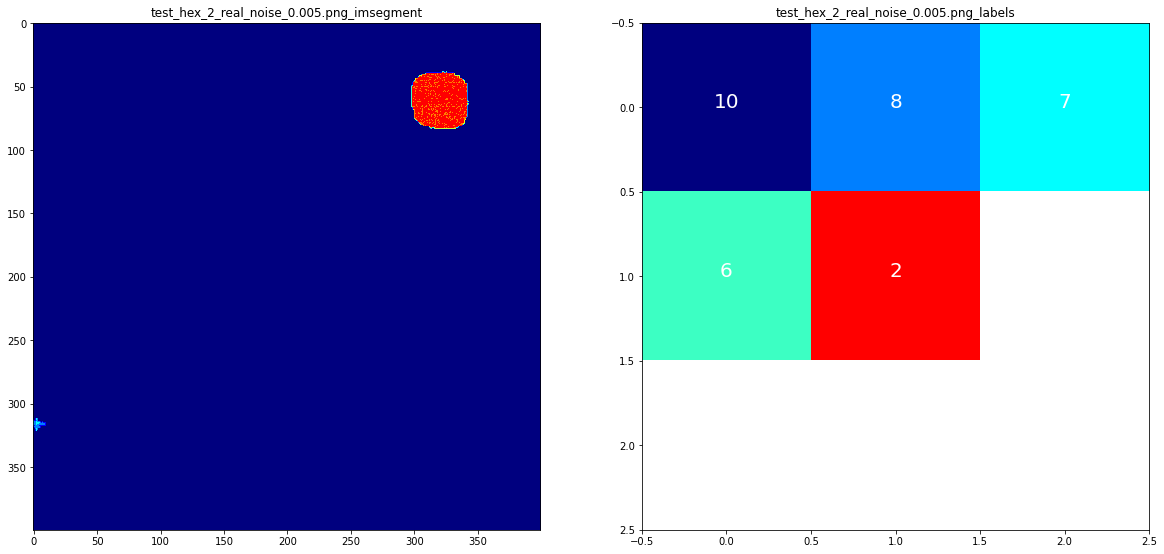

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.005.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.005.png',cmap=cmap,norm=norm)

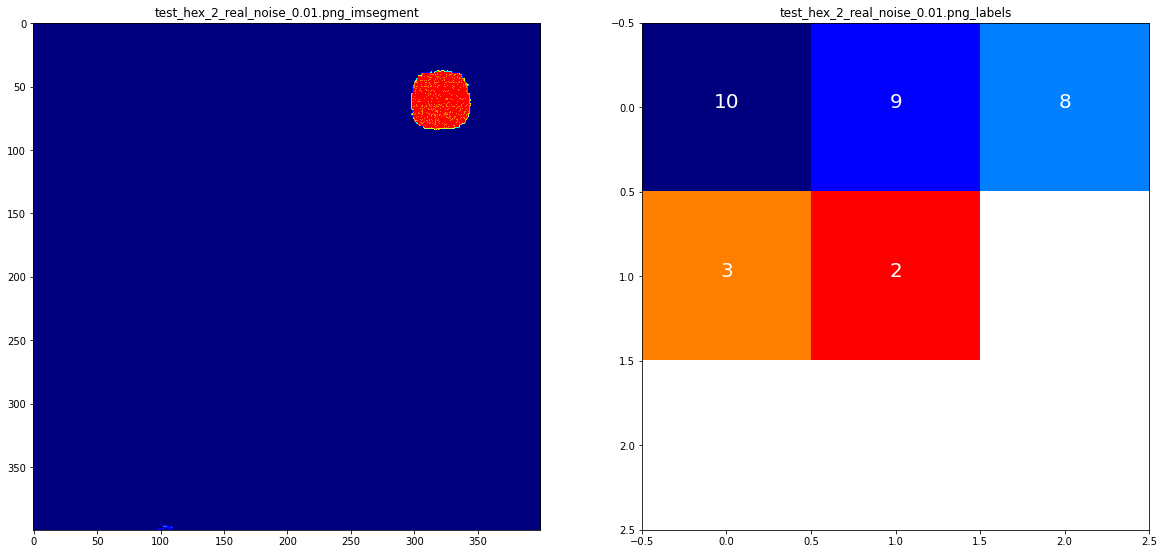

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.01.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.01.png',cmap=cmap,norm=norm)

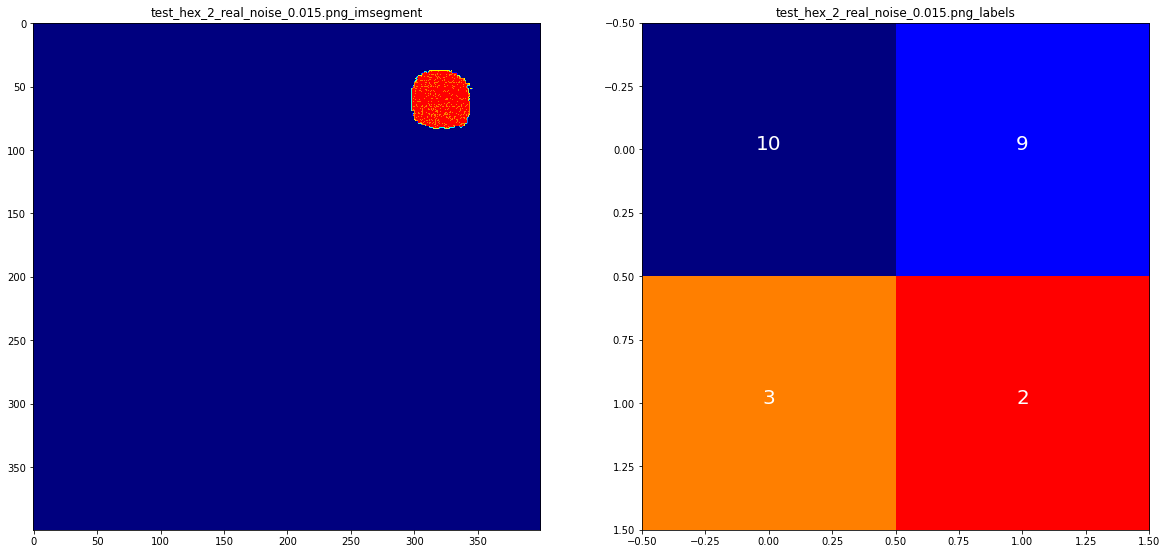

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.015.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.015.png',cmap=cmap,norm=norm)

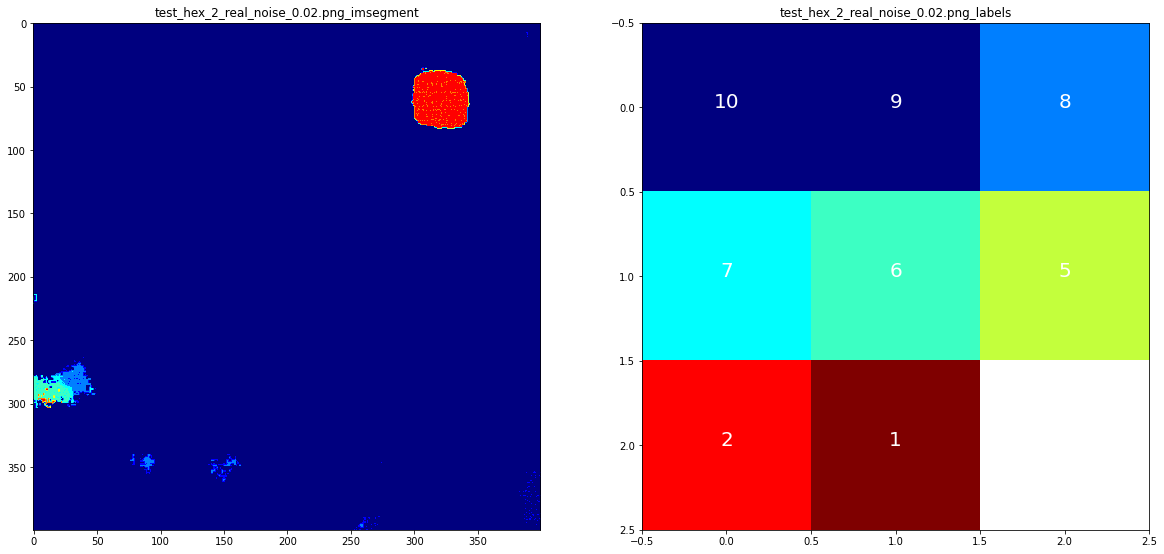

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.02.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.02.png',cmap=cmap,norm=norm)

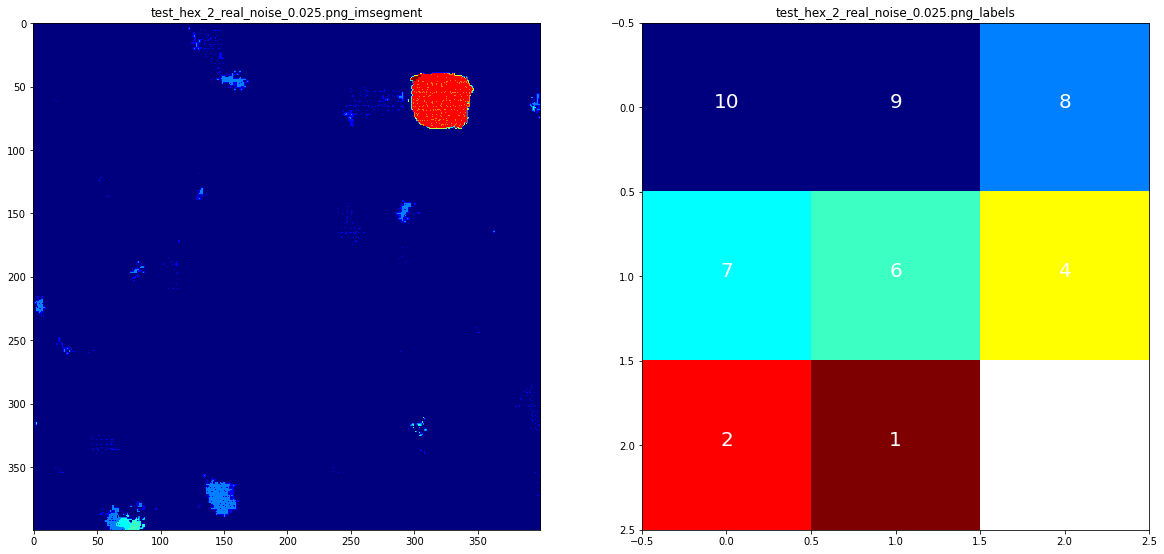

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.025.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.025.png',cmap=cmap,norm=norm)

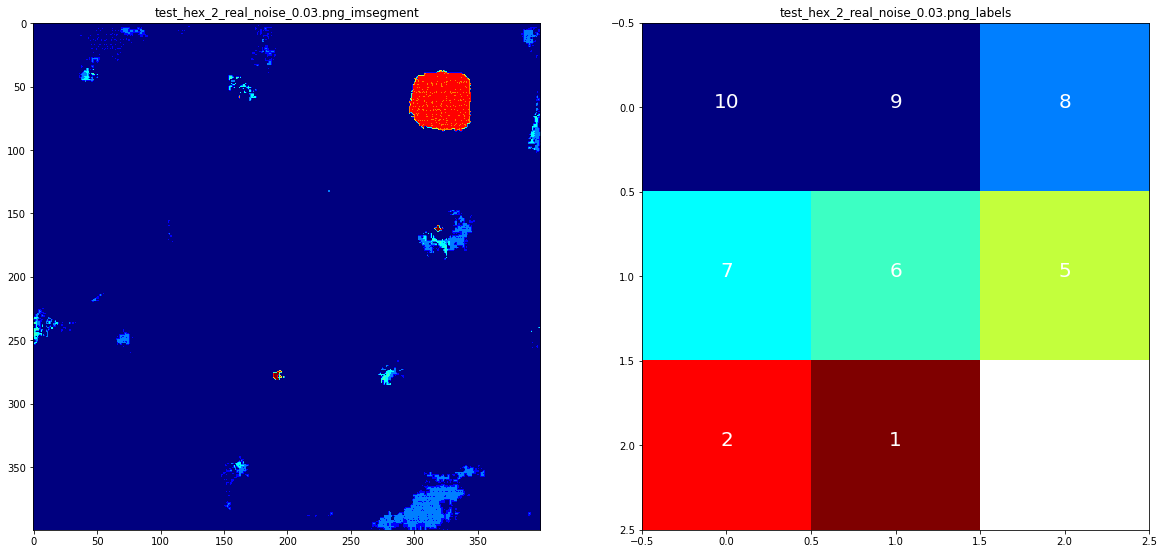

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.03.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.03.png',cmap=cmap,norm=norm)

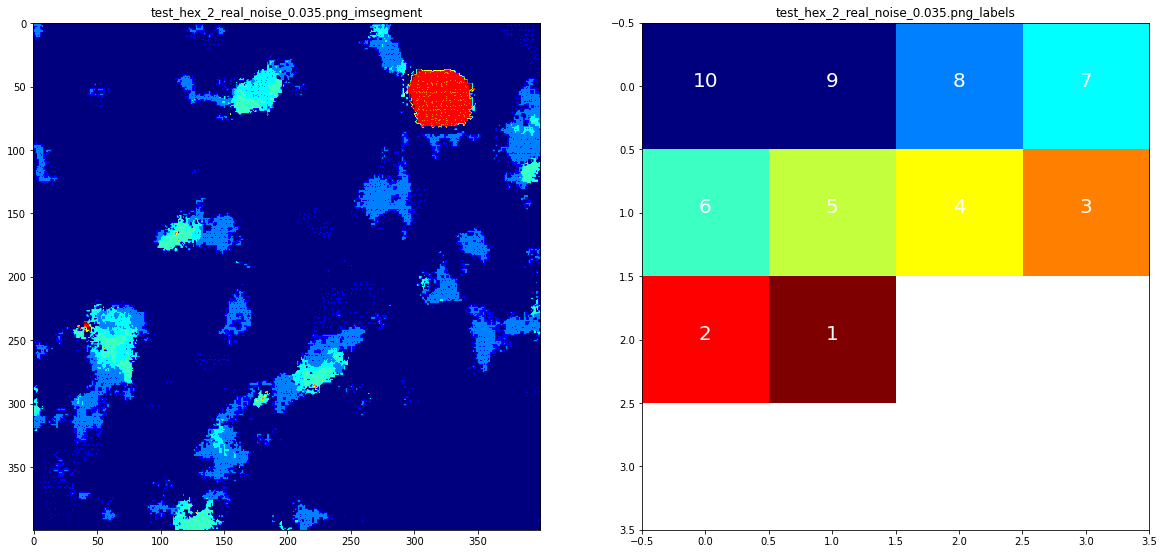

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.035.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.035.png',cmap=cmap,norm=norm)

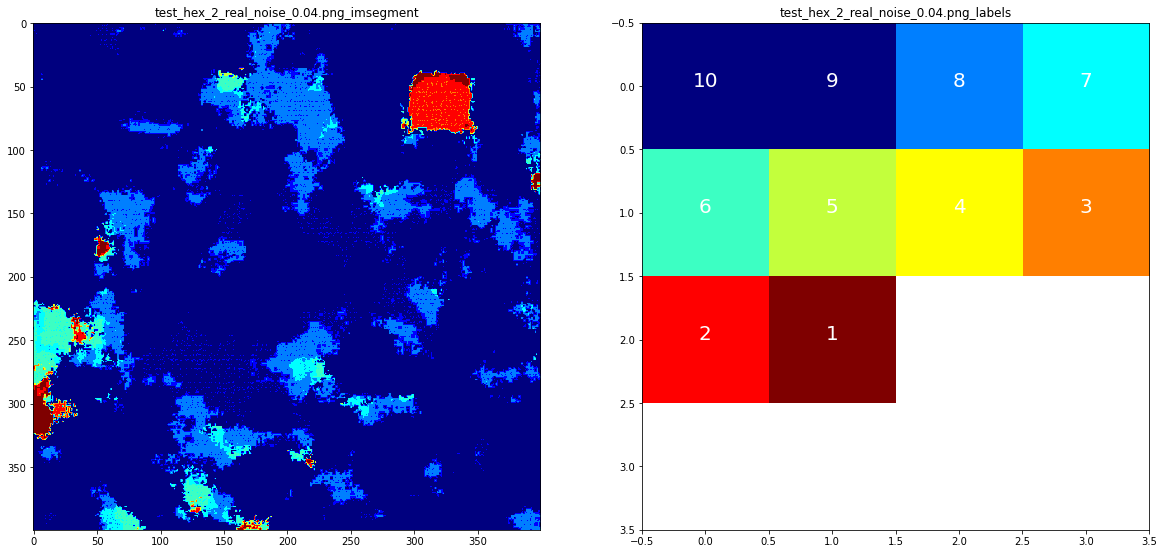

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.04.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.04.png',cmap=cmap,norm=norm)

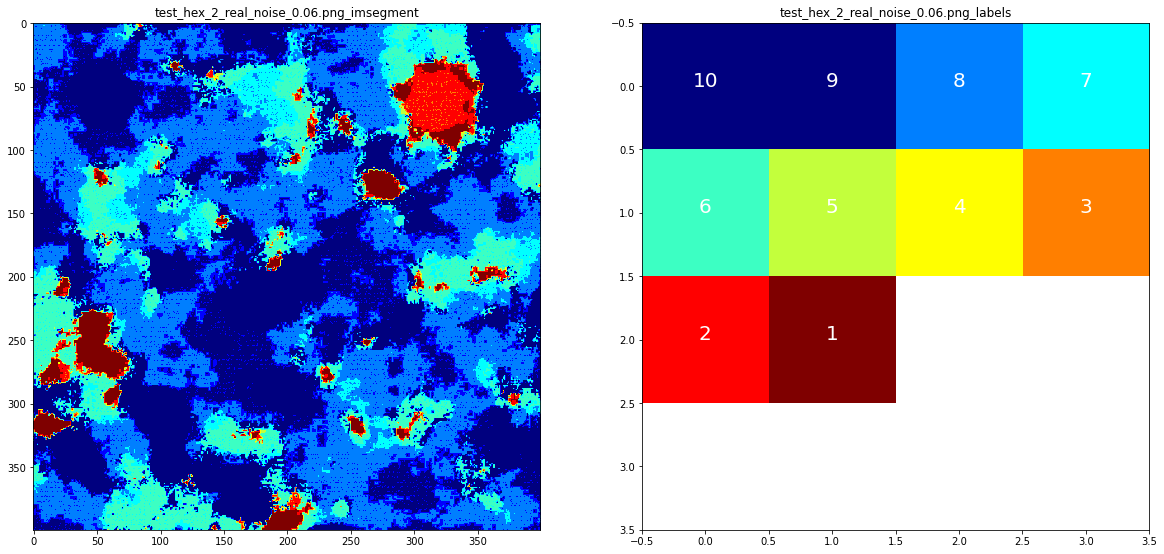

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.06.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.06.png',cmap=cmap,norm=norm)

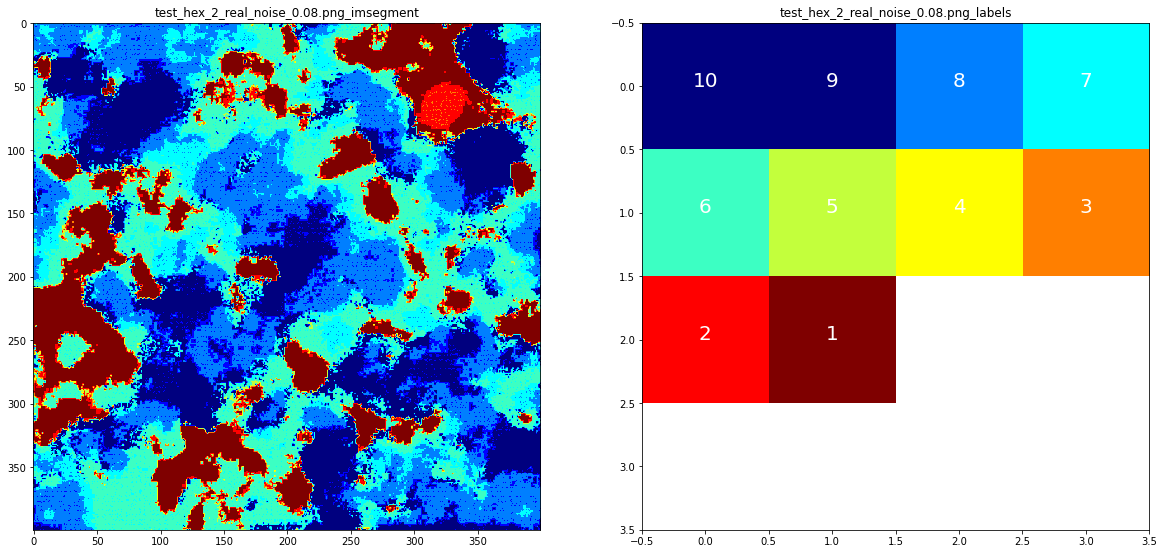

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.08.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.08.png',cmap=cmap,norm=norm)

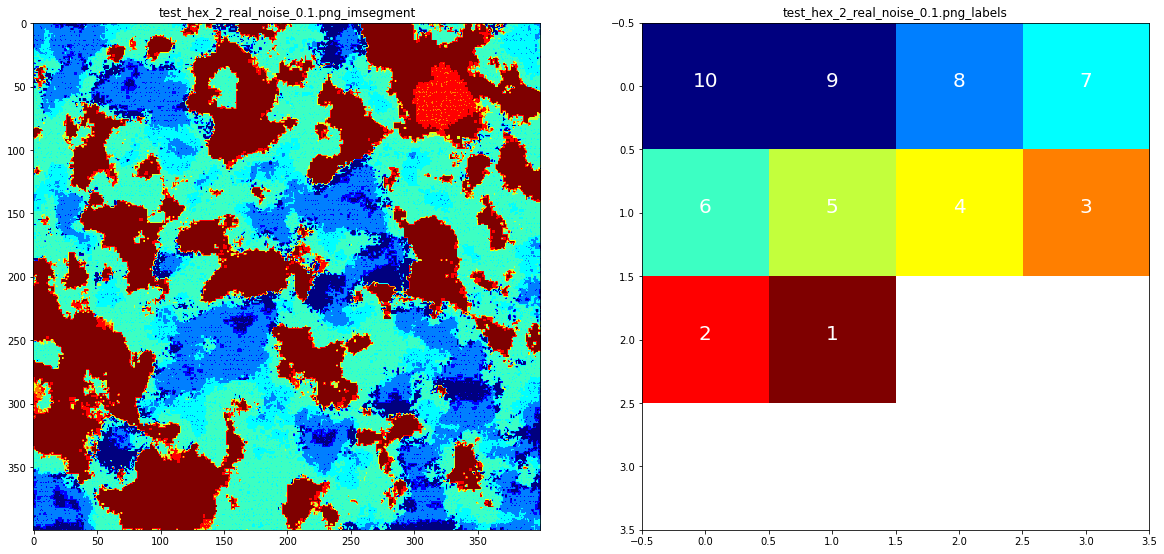

In [ ]:
res = learn.predict(open_image(path_noise/'test_hex_2_real_noise_0.1.png'))
interp._interp_show(res[0],classes,title_suffix='test_hex_2_real_noise_0.1.png',cmap=cmap,norm=norm)

In [ ]:
# Export trained model
learn.export(folder_path+'/models/real-noise0.004-export.pkl')

In [ ]:
# Load trained model
learn1 = load_learner(path=folder_path+'/models',file='real-noise0.004-export.pkl')